In [1]:
import numpy as np

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

**Answer to Question 1:**

In [10]:
from scipy import optimize
from scipy import interpolate

In [11]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def disutility(gamma, l):
    return gamma*l

def v2(c2, l2, rho, gamma):
    if l2 == 0: 
        c = b
    elif l2 == 1:
        c = w * h2 
    return utility(c2,rho) - disutility(gamma, l2)

def v1(c1, l1, rho, gamma, beta, w, h1, Delta, v2_interp):
    
    # a. v2 value, if l = 0
    h2_low = h1
    c2_low = b
    v2_low = v2_interp([h2_low, c2_low])[0]
    
    # b. v2 value, if l
    h2_high = h1 + l1 + Delta
    c2_high = w * h2
    v2_high = v2_interp([h2_high, c2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

In [30]:
def solve_period_2(rho, l2, gamma, Delta):

    # a. grids
    h2_vec = np.linspace(0.1, 1.5, 100) 
    v2_vec = np.empty(100)
    c2_vec = np.empty(100)

    # b. solve for each m2 in grid
    for i, h2 in enumerate(h2_vec):

        # i. objective
        obj = lambda c2: -v2(c2, l2, rho, gamma)

        # ii. initial value (consume half)
        x0 = h2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,h2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return h2_vec,v2_vec,c2_vec

In [33]:
def solve_period_1(rho, gamma, beta, w, Delta, v1, v2_interp):

    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,h1 in enumerate(h1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1, l1, rho, gamma, beta, w, h1, Delta, v2_interp)
        
        # ii. initial guess (consume half)
        x0 = h1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,h1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return h1_vec,v1_vec,c1_vec

In [35]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1
l2 = 0
l1 = 1

def solve(rho, gamma, w, beta, Delta, v1):
    
    # a. solve period 2
    h2_vec,v2_vec,c2_vec = solve_period_2(rho, l2, gamma, Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((h2_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    # b. solve period 1
    h1_vec,v1_vec,c1_vec = solve_period_1(rho, gamma, beta, w, Delta, v1, v2_interp)
    
    return h1_vec,c1_vec

h1_vec,c1_vec = solve(rho, gamma, w, beta, Delta,v1)

NameError: name 'h2' is not defined

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [10]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Answer to question 1:**

In [1]:
#Importing all the necessary packages and activating pretty printing

import numpy as np
import sympy as sm
import matplotlib.pyplot as plt

sm.init_printing(use_unicode=True)

In [2]:
#Defining all the needed variables for the symbolic solution

v = sm.symbols('v_t')
y_t = sm.symbols('y_t')  
pi_t = sm.symbols('pi_t') 
h = sm.symbols('h')
alpha = sm.symbols('alpha')
b = sm.symbols('b')

pi_t_1 = sm.symbols('\pi_{t-1}')
y_t_1 = sm.symbols('y_{t-1}')
s_t = sm.symbols('s_t')
s_t_1 = sm.symbols('s_{t-1}')
gamma = sm.symbols('gamma')
phi = sm.symbols('\phi')

 
h, alpha, v, b, y_t, pi_t, pi_t_1, gamma, phi, y_t_1, s_t, s_t_1

In [3]:
AD = sm.Eq(pi_t, (1/(h*alpha))*(v - (1+b*alpha)*y_t))
SRAS = sm.Eq(pi_t, (pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1))
AD, SRAS

**Solving for the equilibrium value of output ($y_{t}$) in three steps:**

1. **Step 1:** Solve AD wrt $\pi_{t}$
2. **Step 2:** Substistute in SRAS equation 
3. **Step 3:** Solve wrt $y_{t}$

In [4]:
AD_1 = sm.solve(AD, pi_t)
AD_1

In [5]:
AD_2 = SRAS.subs(pi_t, AD_1[0])
AD_2

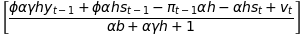

In [6]:
Output = sm.solve(AD_2, y_t)
Output

**Solving for the equilibrium value of inflation ($\pi_{t}$)**

**Note:** This will be done by substituting $y_{t}$ (as calculated above) into the SRAS equation and then solving it wrt $\pi_{t}$

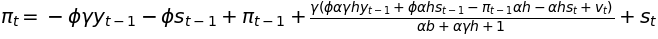

In [7]:
AS_1 = SRAS.subs(y_t, Output[0])
AS_1

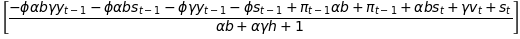

In [8]:
Inflation = sm.solve(AS_1, pi_t)
Inflation

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Answer to Question 2:**

In [11]:
# The two calculated equations are lambdified to be used
sol_output = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Output[0])
sol_inflation = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Inflation[0])

# Set the parameters equal to their values
def _sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)


def _sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)
                         

# The variables' values are inserted into the functions 
A = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
B = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)

C = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
D = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)
      
print('The values of y_t and pi_t when all the variables are equal to zero:')
print(f'y_t = {A}')
print(f'pi_t = {C}')
print('The values of y_t and pi_t when all the variables are equal to zero, except v = 0.1')
print(f'y_t = {B}')
print(f'pi_t = {D}')

The values of y_t and pi_t when all the variables are equal to zero:
y_t = 0.0
pi_t = 0.0
The values of y_t and pi_t when all the variables are equal to zero, except v = 0.1
y_t = 0.0244140625
pi_t = 0.0018310546875


**Conclusion:** from the above calculated values, we can conclude that when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$, the equlibrium is $(\pi_t,y_t) = (0,0)$. On the other hand when the economy suffers from a positive demand shock ($v_t = 0.1$ and the rest of the parameters are equal to zero), the equilibrium is $(\pi_t,y_t) = (0.0244140625,0.0018310546875)$.

**Note:** To plot the AD-SRAS we need the equations to express the relationship between $\pi_t$ and $y_t$; the lambdified equations don't express directly that relationship, so we will define the original AD and SRAS functions and then plot them. 

In [12]:
# Defining the AD and SRAS functions to plot them
def AD(h, alpha, v, b, y_t):
    return (1/(h*alpha))*(v - (1+b*alpha)*y_t)
    
def SRAS(pi_t_1, gamma, y_t, phi, y_t_1, s_t, s_t_1):
    return (pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1)

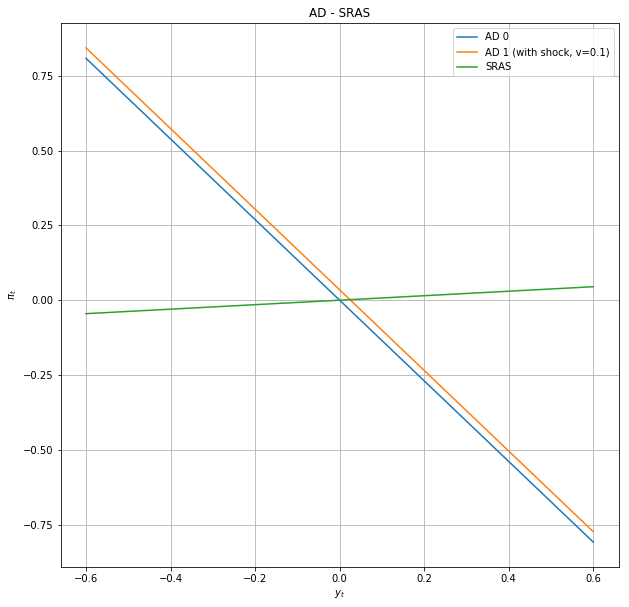

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

y_lin = np.linspace(-0.6, 0.6, 100)
AD_0 = AD(h=par['h'], alpha=par['alpha'], v=0, b=par['b'], y_t=y_lin)
AD_1 = AD(h=par['h'], alpha=par['alpha'], v=0.1, b=par['b'],y_t=y_lin)
SRAS_total = SRAS(pi_t_1=0, gamma=par['gamma'], y_t=y_lin, phi=par['phi'], y_t_1=0, s_t=0, s_t_1=0) 

plt.plot(y_lin, AD_0, label='AD 0')
plt.plot(y_lin, AD_1, label='AD 1 (with shock, v=0.1)')
plt.plot(y_lin, SRAS_total, label='SRAS')
plt.grid(True)

plt.title('AD - SRAS')
plt.xlabel('$y_t$')
plt.ylabel('$\pi_t$')
plt.legend(loc='upper right')
plt.show()

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [14]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Answer to Question 3:**

First we will define the functions of the two shocks, which will be used to fill the vectors of $v_{t}$ and $s_{t}$

**!!!Note:** don't forget to run the above cell with the parameter values

In [15]:
def v_t(v_t_1, x_t, delta=par['delta']):
    return delta*v_t_1 + x_t

def s_t(s_t_1, c_t, omega=par['omega']):
    return omega*s_t_1 + c_t

In [22]:
# Define three periods to check which one will be better
T1 = 25
#T2 = 50
#T3 = 100

# Creating the vectors that will be needed for the simulation
y_vec = [0]
pi_vec = [0]
v_vec = [0]
x_vec = np.zeros(T1) #all the demand shocks to be equal to 0
x_vec[0] = 0.1 #only the shock in the first period should not be equal to 0 
s_vec = [0]
c_vec = np.zeros(T1) #all the supply shocks are 0 

#x_vec

In [23]:
for t in range (1,T1):
    
    v_vec.append(v_t(v_vec[t-1],x_vec[t]))
    s_vec.append(s_t(s_vec[t-1],c_vec[t]))
    y_vec.append(AD(h=par['h'], alpha=par['alpha'], v=v_vec[t], b=par['b'], y_t=y_vec[t]))
    pi_vec.append(SRAS(pi_t_1=pi_vec[t-1], gamma=par['gamma'], y_t=y_vec[t], phi=par['phi'], y_t_1=y_vec[t-1], s_t=s_vec[t], s_t_1=s_vec[t-1]))

IndexError: list index out of range

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [ ]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [33]:
import numpy as np
import scipy as sp
from scipy import interpolate
import sympy as sm
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
sm.init_printing(use_unicode=True)



In [34]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Since budget share is given by Demand/Income:
$$
\begin{eqnarray*}
\frac{x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})}{I^j}&=&\frac{\beta^{j}_i\frac{I^j}{p_{i}}}{I^j}&=&\frac{\beta^{j}_i}{p_{i}}  \\
\end{eqnarray*}
$$
we can get the histogram of budget shares by ploting betas.


Text(0.5, 1.0, 'the budget shares of three goods')

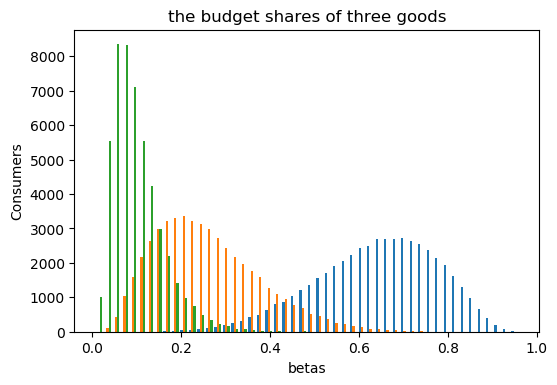

In [35]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.hist(betas,bins=50)

ax.set_xlabel('betas')
ax.set_ylabel('Consumers')

ax.set_title('the budget shares of three goods')

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

In [36]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import itertools
import time
from matplotlib.ticker import FuncFormatter


In [37]:
#demand function
def demand_good_1_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,0]*I/p1

def demand_good_2_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,1]*I/p2

def demand_good_3_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,2]*I
    

In [38]:
def excess_demand_good_1_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_1_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e1)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_2_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_2_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e2)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_3_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_2_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e3)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

In [39]:
p1_s = np.linspace(1,10,100)
p2_s = np.linspace(1,10,100)

In [40]:
# Initiating empty grids for excess demands
excess_1_grid = np.empty((100,100))
excess_2_grid = np.empty((100,100))

# Calculating excess-demands for each price-combination
for i,p1 in enumerate(p1_s):
    for j,p2 in enumerate(p2_s):
        excess_1_grid[i,j] = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        excess_2_grid[i,j] = excess_demand_good_2_func(betas,p1,p2,e1,e2,e3)
        
p1_grid, p2_grid = np.meshgrid(p1_s, p2_s) 

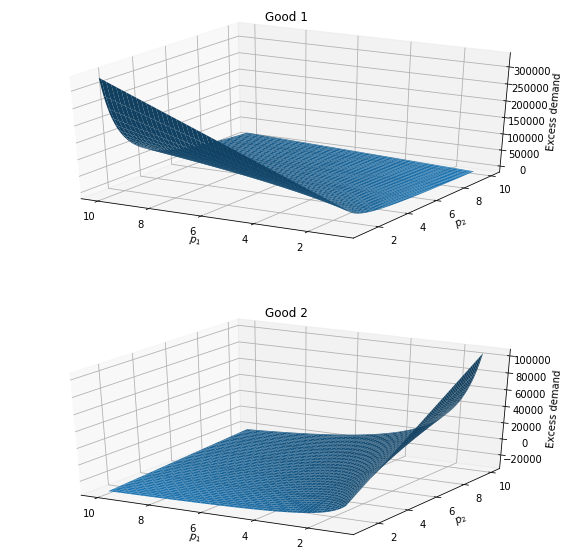

In [41]:
fig = plt.figure(figsize=(10,10))

ex1 = fig.add_subplot(2,1,1, projection='3d')
fig1 = ex1.plot_surface(p1_grid,p2_grid,excess_1_grid)
ex1.invert_xaxis()

ex1.set_xlabel('$p_1$')
ex1.set_ylabel('$p_2$')
ex1.set_zlabel('Excess demand')
ex1.set_title('Good 1')

ex2 = fig.add_subplot(2,1,2, projection='3d')
fig2=ex2.plot_surface(p1_grid,p2_grid,excess_2_grid)
ex2.invert_xaxis()

ex2.set_xlabel('$p_1$')
ex2.set_ylabel('$p_2$')
ex2.set_zlabel('Excess demand')
ex2.set_title('Good 2')

plt.show()

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [42]:
def find_equilibrium(betas,p1,p2,e1,e2,e3,kappa=0.1,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. step 1: excess demand
        Z1 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        Z2 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        
        # b: step 2: stop?
        if  np.abs(Z1) < eps and np.abs(Z2) < eps:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N
            
        # d. step 4: return 
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1,p2

In [43]:
p1 = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8

p1 = find_equilibrium(betas,p1,p2,e1,e2,e3=2.054,kappa=kappa,eps=eps)

  0: p1 =   1.50417427 -> excess demand -> 52087.13710475
  1: p1 =   1.60308604 -> excess demand -> 49455.88229365
  2: p1 =   1.69763414 -> excess demand -> 47274.04893541
  3: p1 =   1.78848642 -> excess demand -> 45426.14035998
  4: p1 =   1.87615549 -> excess demand -> 43834.53752320
   ...
 25: p1 =   3.34537114 -> excess demand -> 30287.13100115
 50: p1 =   4.71768575 -> excess demand -> 25492.13623260
 75: p1 =   5.92570965 -> excess demand -> 23141.17104004
100: p1 =   7.04264799 -> excess demand -> 21693.75038523
125: p1 =   8.09999515 -> excess demand -> 20694.77675830
150: p1 =   9.11467572 -> excess demand -> 19955.69085316
175: p1 =  10.09699949 -> excess demand -> 19382.58793826
200: p1 =  11.05378173 -> excess demand -> 18922.84429528
225: p1 =  11.98979624 -> excess demand -> 18544.42391175
250: p1 =  12.90853482 -> excess demand -> 18226.58586776
275: p1 =  13.81263901 -> excess demand -> 17955.24649472
300: p1 =  14.70416179 -> excess demand -> 17720.47174380
325: p1

3625: p1 = 115.47137529 -> excess demand -> 14555.14850474
3650: p1 = 116.19905752 -> excess demand -> 14552.26237946
3675: p1 = 116.92659640 -> excess demand -> 14549.41274472
3700: p1 = 117.65399373 -> excess demand -> 14546.59890604
3725: p1 = 118.38125128 -> excess demand -> 14543.82018656
3750: p1 = 119.10837080 -> excess demand -> 14541.07592652
3775: p1 = 119.83535399 -> excess demand -> 14538.36548266
3800: p1 = 120.56220251 -> excess demand -> 14535.68822778
3825: p1 = 121.28891803 -> excess demand -> 14533.04355018
3850: p1 = 122.01550215 -> excess demand -> 14530.43085320
3875: p1 = 122.74195644 -> excess demand -> 14527.84955477
3900: p1 = 123.46828248 -> excess demand -> 14525.29908696
3925: p1 = 124.19448179 -> excess demand -> 14522.77889553
3950: p1 = 124.92055586 -> excess demand -> 14520.28843955
3975: p1 = 125.64650617 -> excess demand -> 14517.82719098
4000: p1 = 126.37233416 -> excess demand -> 14515.39463429
4025: p1 = 127.09804126 -> excess demand -> 14512.990266

7350: p1 = 222.89889806 -> excess demand -> 14333.05847154
7375: p1 = 223.61553108 -> excess demand -> 14332.29353043
7400: p1 = 224.33212598 -> excess demand -> 14331.53351750
7425: p1 = 225.04868300 -> excess demand -> 14330.77838503
7450: p1 = 225.76520239 -> excess demand -> 14330.02808589
7475: p1 = 226.48168439 -> excess demand -> 14329.28257360
7500: p1 = 227.19812924 -> excess demand -> 14328.54180225
7525: p1 = 227.91453717 -> excess demand -> 14327.80572650
7550: p1 = 228.63090842 -> excess demand -> 14327.07430163
7575: p1 = 229.34724322 -> excess demand -> 14326.34748347
7600: p1 = 230.06354180 -> excess demand -> 14325.62522839
7625: p1 = 230.77980438 -> excess demand -> 14324.90749334
7650: p1 = 231.49603119 -> excess demand -> 14324.19423580
7675: p1 = 232.21222245 -> excess demand -> 14323.48541378
7700: p1 = 232.92837839 -> excess demand -> 14322.78098582
7725: p1 = 233.64449922 -> excess demand -> 14322.08091099
7750: p1 = 234.36058516 -> excess demand -> 14321.385148

11075: p1 = 329.35526506 -> excess demand -> 14255.91098006
11100: p1 = 330.06805153 -> excess demand -> 14255.56216478
11125: p1 = 330.78082060 -> excess demand -> 14255.21486138
11150: p1 = 331.49357235 -> excess demand -> 14254.86906003
11175: p1 = 332.20630685 -> excess demand -> 14254.52475097
11200: p1 = 332.91902416 -> excess demand -> 14254.18192452
11225: p1 = 333.63172438 -> excess demand -> 14253.84057109
11250: p1 = 334.34440756 -> excess demand -> 14253.50068118
11275: p1 = 335.05707379 -> excess demand -> 14253.16224535
11300: p1 = 335.76972314 -> excess demand -> 14252.82525426
11325: p1 = 336.48235567 -> excess demand -> 14252.48969865
11350: p1 = 337.19497146 -> excess demand -> 14252.15556933
11375: p1 = 337.90757058 -> excess demand -> 14251.82285719
11400: p1 = 338.62015311 -> excess demand -> 14251.49155321
11425: p1 = 339.33271910 -> excess demand -> 14251.16164843
11450: p1 = 340.04526864 -> excess demand -> 14250.83313397
11475: p1 = 340.75780178 -> excess deman

14550: p1 = 428.29276560 -> excess demand -> 14218.59877085
14575: p1 = 429.00369019 -> excess demand -> 14218.39294105
14600: p1 = 429.71460450 -> excess demand -> 14218.18779530
14625: p1 = 430.42550857 -> excess demand -> 14217.98333020
14650: p1 = 431.13640243 -> excess demand -> 14217.77954236
14675: p1 = 431.84728613 -> excess demand -> 14217.57642840
14700: p1 = 432.55815968 -> excess demand -> 14217.37398498
14725: p1 = 433.26902313 -> excess demand -> 14217.17220878
14750: p1 = 433.97987651 -> excess demand -> 14216.97109648
14775: p1 = 434.69071985 -> excess demand -> 14216.77064482
14800: p1 = 435.40155319 -> excess demand -> 14216.57085053
14825: p1 = 436.11237655 -> excess demand -> 14216.37171037
14850: p1 = 436.82318997 -> excess demand -> 14216.17322113
14875: p1 = 437.53399348 -> excess demand -> 14215.97537962
14900: p1 = 438.24478712 -> excess demand -> 14215.77818265
14925: p1 = 438.95557092 -> excess demand -> 14215.58162708
14950: p1 = 439.66634490 -> excess deman

18200: p1 = 531.99373919 -> excess demand -> 14194.38756583
18225: p1 = 532.70345510 -> excess demand -> 14194.25434639
18250: p1 = 533.41316436 -> excess demand -> 14194.12148271
18275: p1 = 534.12286699 -> excess demand -> 14193.98897337
18300: p1 = 534.83256300 -> excess demand -> 14193.85681695
18325: p1 = 535.54225241 -> excess demand -> 14193.72501204
18350: p1 = 536.25193524 -> excess demand -> 14193.59355723
18375: p1 = 536.96161151 -> excess demand -> 14193.46245113
18400: p1 = 537.67128123 -> excess demand -> 14193.33169235
18425: p1 = 538.38094442 -> excess demand -> 14193.20127951
18450: p1 = 539.09060111 -> excess demand -> 14193.07121123
18475: p1 = 539.80025129 -> excess demand -> 14192.94148614
18500: p1 = 540.50989500 -> excess demand -> 14192.81210290
18525: p1 = 541.21953225 -> excess demand -> 14192.68306013
18550: p1 = 541.92916305 -> excess demand -> 14192.55435651
18575: p1 = 542.63878743 -> excess demand -> 14192.42599069
18600: p1 = 543.34840540 -> excess deman

21875: p1 = 636.25865301 -> excess demand -> 14178.00170546
21900: p1 = 636.96755067 -> excess demand -> 14177.90865898
21925: p1 = 637.67644369 -> excess demand -> 14177.81581999
21950: p1 = 638.38533207 -> excess demand -> 14177.72318780
21975: p1 = 639.09421583 -> excess demand -> 14177.63076172
22000: p1 = 639.80309497 -> excess demand -> 14177.53854107
22025: p1 = 640.51196950 -> excess demand -> 14177.44652514
22050: p1 = 641.22083944 -> excess demand -> 14177.35471327
22075: p1 = 641.92970479 -> excess demand -> 14177.26310477
22100: p1 = 642.63856557 -> excess demand -> 14177.17169897
22125: p1 = 643.34742178 -> excess demand -> 14177.08049519
22150: p1 = 644.05627344 -> excess demand -> 14176.98949277
22175: p1 = 644.76512055 -> excess demand -> 14176.89869103
22200: p1 = 645.47396313 -> excess demand -> 14176.80808931
22225: p1 = 646.18280119 -> excess demand -> 14176.71768695
22250: p1 = 646.89163472 -> excess demand -> 14176.62748329
22275: p1 = 647.60046376 -> excess deman

25525: p1 = 739.71322756 -> excess demand -> 14166.30893788
25550: p1 = 740.42154122 -> excess demand -> 14166.24014474
25575: p1 = 741.12985144 -> excess demand -> 14166.17148343
25600: p1 = 741.83815823 -> excess demand -> 14166.10295357
25625: p1 = 742.54646160 -> excess demand -> 14166.03455479
25650: p1 = 743.25476155 -> excess demand -> 14165.96628671
25675: p1 = 743.96305810 -> excess demand -> 14165.89814895
25700: p1 = 744.67135123 -> excess demand -> 14165.83014114
25725: p1 = 745.37964098 -> excess demand -> 14165.76226291
25750: p1 = 746.08792733 -> excess demand -> 14165.69451389
25775: p1 = 746.79621029 -> excess demand -> 14165.62689370
25800: p1 = 747.50448988 -> excess demand -> 14165.55940199
25825: p1 = 748.21276610 -> excess demand -> 14165.49203838
25850: p1 = 748.92103895 -> excess demand -> 14165.42480251
25875: p1 = 749.62930845 -> excess demand -> 14165.35769402
25900: p1 = 750.33757459 -> excess demand -> 14165.29071254
25925: p1 = 751.04583739 -> excess deman

29150: p1 = 842.38580726 -> excess demand -> 14157.54417903
29175: p1 = 843.09368309 -> excess demand -> 14157.49116045
29200: p1 = 843.80155627 -> excess demand -> 14157.43823103
29225: p1 = 844.50942681 -> excess demand -> 14157.38539054
29250: p1 = 845.21729471 -> excess demand -> 14157.33263876
29275: p1 = 845.92515997 -> excess demand -> 14157.27997547
29300: p1 = 846.63302260 -> excess demand -> 14157.22740043
29325: p1 = 847.34088261 -> excess demand -> 14157.17491343
29350: p1 = 848.04873999 -> excess demand -> 14157.12251425
29375: p1 = 848.75659476 -> excess demand -> 14157.07020267
29400: p1 = 849.46444691 -> excess demand -> 14157.01797847
29425: p1 = 850.17229645 -> excess demand -> 14156.96584142
29450: p1 = 850.88014339 -> excess demand -> 14156.91379131
29475: p1 = 851.58798773 -> excess demand -> 14156.86182793
29500: p1 = 852.29582947 -> excess demand -> 14156.80995105
29525: p1 = 853.00366862 -> excess demand -> 14156.75816047
29550: p1 = 853.71150518 -> excess deman

32800: p1 = 945.70971862 -> excess demand -> 14150.64514616
32825: p1 = 946.41724978 -> excess demand -> 14150.60309677
32850: p1 = 947.12477884 -> excess demand -> 14150.56111033
32875: p1 = 947.83230581 -> excess demand -> 14150.51918669
32900: p1 = 948.53983068 -> excess demand -> 14150.47732573
32925: p1 = 949.24735346 -> excess demand -> 14150.43552729
32950: p1 = 949.95487415 -> excess demand -> 14150.39379125
32975: p1 = 950.66239275 -> excess demand -> 14150.35211744
33000: p1 = 951.36990928 -> excess demand -> 14150.31050575
33025: p1 = 952.07742372 -> excess demand -> 14150.26895603
33050: p1 = 952.78493609 -> excess demand -> 14150.22746814
33075: p1 = 953.49244639 -> excess demand -> 14150.18604194
33100: p1 = 954.19995461 -> excess demand -> 14150.14467730
33125: p1 = 954.90746077 -> excess demand -> 14150.10337407
33150: p1 = 955.61496487 -> excess demand -> 14150.06213213
33175: p1 = 956.32246691 -> excess demand -> 14150.02095133
33200: p1 = 957.02996688 -> excess deman

36425: p1 = 1048.28125413 -> excess demand -> 14145.14157526
36450: p1 = 1048.98851032 -> excess demand -> 14145.10736312
36475: p1 = 1049.69576480 -> excess demand -> 14145.07319716
36500: p1 = 1050.40301757 -> excess demand -> 14145.03907729
36525: p1 = 1051.11026864 -> excess demand -> 14145.00500343
36550: p1 = 1051.81751801 -> excess demand -> 14144.97097547
36575: p1 = 1052.52476567 -> excess demand -> 14144.93699332
36600: p1 = 1053.23201164 -> excess demand -> 14144.90305689
36625: p1 = 1053.93925591 -> excess demand -> 14144.86916610
36650: p1 = 1054.64649849 -> excess demand -> 14144.83532083
36675: p1 = 1055.35373937 -> excess demand -> 14144.80152102
36700: p1 = 1056.06097857 -> excess demand -> 14144.76776655
36725: p1 = 1056.76821608 -> excess demand -> 14144.73405735
36750: p1 = 1057.47545191 -> excess demand -> 14144.70039332
36775: p1 = 1058.18268606 -> excess demand -> 14144.66677437
36800: p1 = 1058.88991852 -> excess demand -> 14144.63320041
36825: p1 = 1059.5971493

40100: p1 = 1152.23068579 -> excess demand -> 14140.56378493
40125: p1 = 1152.93771324 -> excess demand -> 14140.53547486
40150: p1 = 1153.64473928 -> excess demand -> 14140.50719955
40175: p1 = 1154.35176390 -> excess demand -> 14140.47895893
40200: p1 = 1155.05878712 -> excess demand -> 14140.45075294
40225: p1 = 1155.76580892 -> excess demand -> 14140.42258151
40250: p1 = 1156.47282932 -> excess demand -> 14140.39444459
40275: p1 = 1157.17984831 -> excess demand -> 14140.36634211
40300: p1 = 1157.88686590 -> excess demand -> 14140.33827401
40325: p1 = 1158.59388208 -> excess demand -> 14140.31024021
40350: p1 = 1159.30089687 -> excess demand -> 14140.28224067
40375: p1 = 1160.00791025 -> excess demand -> 14140.25427532
40400: p1 = 1160.71492224 -> excess demand -> 14140.22634408
40425: p1 = 1161.42193283 -> excess demand -> 14140.19844692
40450: p1 = 1162.12894203 -> excess demand -> 14140.17058375
40475: p1 = 1162.83594983 -> excess demand -> 14140.14275451
40500: p1 = 1163.5429562

43625: p1 = 1251.90834128 -> excess demand -> 14136.88812807
43650: p1 = 1252.61518506 -> excess demand -> 14136.86415181
43675: p1 = 1253.32202765 -> excess demand -> 14136.84020263
43700: p1 = 1254.02886904 -> excess demand -> 14136.81628049
43725: p1 = 1254.73570923 -> excess demand -> 14136.79238535
43750: p1 = 1255.44254823 -> excess demand -> 14136.76851715
43775: p1 = 1256.14938603 -> excess demand -> 14136.74467586
43800: p1 = 1256.85622265 -> excess demand -> 14136.72086142
43825: p1 = 1257.56305807 -> excess demand -> 14136.69707379
43850: p1 = 1258.26989231 -> excess demand -> 14136.67331293
43875: p1 = 1258.97672536 -> excess demand -> 14136.64957879
43900: p1 = 1259.68355722 -> excess demand -> 14136.62587133
43925: p1 = 1260.39038790 -> excess demand -> 14136.60219049
43950: p1 = 1261.09721739 -> excess demand -> 14136.57853625
43975: p1 = 1261.80404570 -> excess demand -> 14136.55490854
44000: p1 = 1262.51087284 -> excess demand -> 14136.53130733
44025: p1 = 1263.2176987

47250: p1 = 1354.38881680 -> excess demand -> 14133.67318893
47275: p1 = 1355.09549993 -> excess demand -> 14133.65270760
47300: p1 = 1355.80218203 -> excess demand -> 14133.63224765
47325: p1 = 1356.50886311 -> excess demand -> 14133.61180904
47350: p1 = 1357.21554317 -> excess demand -> 14133.59139175
47375: p1 = 1357.92222221 -> excess demand -> 14133.57099574
47400: p1 = 1358.62890023 -> excess demand -> 14133.55062098
47425: p1 = 1359.33557723 -> excess demand -> 14133.53026743
47450: p1 = 1360.04225322 -> excess demand -> 14133.50993506
47475: p1 = 1360.74892818 -> excess demand -> 14133.48962385
47500: p1 = 1361.45560214 -> excess demand -> 14133.46933374
47525: p1 = 1362.16227508 -> excess demand -> 14133.44906472
47550: p1 = 1362.86894700 -> excess demand -> 14133.42881675
47575: p1 = 1363.57561792 -> excess demand -> 14133.40858979
47600: p1 = 1364.28228782 -> excess demand -> 14133.38838382
47625: p1 = 1364.98895672 -> excess demand -> 14133.36819879
47650: p1 = 1365.6956246

50725: p1 = 1452.60839921 -> excess demand -> 14131.01765212
50750: p1 = 1453.31494963 -> excess demand -> 14130.99984964
50775: p1 = 1454.02149916 -> excess demand -> 14130.98206449
50800: p1 = 1454.72804780 -> excess demand -> 14130.96429664
50825: p1 = 1455.43459555 -> excess demand -> 14130.94654606
50850: p1 = 1456.14114242 -> excess demand -> 14130.92881273
50875: p1 = 1456.84768840 -> excess demand -> 14130.91109662
50900: p1 = 1457.55423349 -> excess demand -> 14130.89339771
50925: p1 = 1458.26077770 -> excess demand -> 14130.87571598
50950: p1 = 1458.96732103 -> excess demand -> 14130.85805139
50975: p1 = 1459.67386347 -> excess demand -> 14130.84040392
51000: p1 = 1460.38040503 -> excess demand -> 14130.82277356
51025: p1 = 1461.08694571 -> excess demand -> 14130.80516026
51050: p1 = 1461.79348551 -> excess demand -> 14130.78756402
51075: p1 = 1462.50002444 -> excess demand -> 14130.76998480
51100: p1 = 1463.20656248 -> excess demand -> 14130.75242258
51125: p1 = 1463.9130996

54200: p1 = 1550.81073591 -> excess demand -> 14128.69887251
54225: p1 = 1551.51717045 -> excess demand -> 14128.68325539
54250: p1 = 1552.22360420 -> excess demand -> 14128.66765250
54275: p1 = 1552.93003718 -> excess demand -> 14128.65206382
54300: p1 = 1553.63646938 -> excess demand -> 14128.63648934
54325: p1 = 1554.34290080 -> excess demand -> 14128.62092903
54350: p1 = 1555.04933144 -> excess demand -> 14128.60538288
54375: p1 = 1555.75576131 -> excess demand -> 14128.58985086
54400: p1 = 1556.46219039 -> excess demand -> 14128.57433296
54425: p1 = 1557.16861871 -> excess demand -> 14128.55882916
54450: p1 = 1557.87504625 -> excess demand -> 14128.54333943
54475: p1 = 1558.58147301 -> excess demand -> 14128.52786376
54500: p1 = 1559.28789900 -> excess demand -> 14128.51240213
54525: p1 = 1559.99432422 -> excess demand -> 14128.49695453
54550: p1 = 1560.70074867 -> excess demand -> 14128.48152092
54575: p1 = 1561.40717234 -> excess demand -> 14128.46610130
54600: p1 = 1562.1135952

57700: p1 = 1649.70428112 -> excess demand -> 14126.64275926
57725: p1 = 1650.41061289 -> excess demand -> 14126.62896006
57750: p1 = 1651.11694398 -> excess demand -> 14126.61517267
57775: p1 = 1651.82327438 -> excess demand -> 14126.60139709
57800: p1 = 1652.52960410 -> excess demand -> 14126.58763329
57825: p1 = 1653.23593312 -> excess demand -> 14126.57388127
57850: p1 = 1653.94226146 -> excess demand -> 14126.56014102
57875: p1 = 1654.64858911 -> excess demand -> 14126.54641250
57900: p1 = 1655.35491607 -> excess demand -> 14126.53269572
57925: p1 = 1656.06124235 -> excess demand -> 14126.51899064
57950: p1 = 1656.76756794 -> excess demand -> 14126.50529727
57975: p1 = 1657.47389285 -> excess demand -> 14126.49161558
58000: p1 = 1658.18021708 -> excess demand -> 14126.47794556
58025: p1 = 1658.88654062 -> excess demand -> 14126.46428720
58050: p1 = 1659.59286348 -> excess demand -> 14126.45064048
58075: p1 = 1660.29918566 -> excess demand -> 14126.43700537
58100: p1 = 1661.0055071

61100: p1 = 1745.75930434 -> excess demand -> 14124.86868126
61125: p1 = 1746.46554745 -> excess demand -> 14124.85636007
61150: p1 = 1747.17178995 -> excess demand -> 14124.84404885
61175: p1 = 1747.87803183 -> excess demand -> 14124.83174760
61200: p1 = 1748.58427310 -> excess demand -> 14124.81945629
61225: p1 = 1749.29051375 -> excess demand -> 14124.80717492
61250: p1 = 1749.99675379 -> excess demand -> 14124.79490347
61275: p1 = 1750.70299322 -> excess demand -> 14124.78264194
61300: p1 = 1751.40923203 -> excess demand -> 14124.77039030
61325: p1 = 1752.11547023 -> excess demand -> 14124.75814855
61350: p1 = 1752.82170782 -> excess demand -> 14124.74591668
61375: p1 = 1753.52794480 -> excess demand -> 14124.73369467
61400: p1 = 1754.23418117 -> excess demand -> 14124.72148251
61425: p1 = 1754.94041692 -> excess demand -> 14124.70928019
61450: p1 = 1755.64665207 -> excess demand -> 14124.69708770
61475: p1 = 1756.35288661 -> excess demand -> 14124.68490502
61500: p1 = 1757.0591205

64575: p1 = 1843.92140061 -> excess demand -> 14123.24664945
64600: p1 = 1844.62756265 -> excess demand -> 14123.23560624
64625: p1 = 1845.33372414 -> excess demand -> 14123.22457150
64650: p1 = 1846.03988509 -> excess demand -> 14123.21354520
64675: p1 = 1846.74604548 -> excess demand -> 14123.20252735
64700: p1 = 1847.45220532 -> excess demand -> 14123.19151793
64725: p1 = 1848.15836461 -> excess demand -> 14123.18051693
64750: p1 = 1848.86452335 -> excess demand -> 14123.16952434
64775: p1 = 1849.57068154 -> excess demand -> 14123.15854015
64800: p1 = 1850.27683918 -> excess demand -> 14123.14756436
64825: p1 = 1850.98299627 -> excess demand -> 14123.13659695
64850: p1 = 1851.68915282 -> excess demand -> 14123.12563791
64875: p1 = 1852.39530881 -> excess demand -> 14123.11468724
64900: p1 = 1853.10146426 -> excess demand -> 14123.10374492
64925: p1 = 1853.80761917 -> excess demand -> 14123.09281095
64950: p1 = 1854.51377352 -> excess demand -> 14123.08188531
64975: p1 = 1855.2199273

68025: p1 = 1941.36671979 -> excess demand -> 14121.79870268
68050: p1 = 1942.07280947 -> excess demand -> 14121.78874110
68075: p1 = 1942.77889865 -> excess demand -> 14121.77878677
68100: p1 = 1943.48498733 -> excess demand -> 14121.76883969
68125: p1 = 1944.19107551 -> excess demand -> 14121.75889983
68150: p1 = 1944.89716320 -> excess demand -> 14121.74896720
68175: p1 = 1945.60325039 -> excess demand -> 14121.73904179
68200: p1 = 1946.30933708 -> excess demand -> 14121.72912358
68225: p1 = 1947.01542328 -> excess demand -> 14121.71921258
68250: p1 = 1947.72150898 -> excess demand -> 14121.70930876
68275: p1 = 1948.42759419 -> excess demand -> 14121.69941214
68300: p1 = 1949.13367891 -> excess demand -> 14121.68952269
68325: p1 = 1949.83976312 -> excess demand -> 14121.67964041
68350: p1 = 1950.54584685 -> excess demand -> 14121.66976529
68375: p1 = 1951.25193008 -> excess demand -> 14121.65989732
68400: p1 = 1951.95801282 -> excess demand -> 14121.65003650
68425: p1 = 1952.6640950

71700: p1 = 2045.15674009 -> excess demand -> 14120.40823031
71725: p1 = 2045.86276027 -> excess demand -> 14120.39925489
71750: p1 = 2046.56878000 -> excess demand -> 14120.39028568
71775: p1 = 2047.27479928 -> excess demand -> 14120.38132265
71800: p1 = 2047.98081811 -> excess demand -> 14120.37236581
71825: p1 = 2048.68683650 -> excess demand -> 14120.36341515
71850: p1 = 2049.39285444 -> excess demand -> 14120.35447066
71875: p1 = 2050.09887193 -> excess demand -> 14120.34553233
71900: p1 = 2050.80488897 -> excess demand -> 14120.33660017
71925: p1 = 2051.51090557 -> excess demand -> 14120.32767416
71950: p1 = 2052.21692172 -> excess demand -> 14120.31875430
71975: p1 = 2052.92293743 -> excess demand -> 14120.30984058
72000: p1 = 2053.62895269 -> excess demand -> 14120.30093299
72025: p1 = 2054.33496750 -> excess demand -> 14120.29203154
72050: p1 = 2055.04098187 -> excess demand -> 14120.28313620
72075: p1 = 2055.74699580 -> excess demand -> 14120.27424698
72100: p1 = 2056.4530092

75200: p1 = 2143.99533395 -> excess demand -> 14119.20923781
75225: p1 = 2144.70129420 -> excess demand -> 14119.20107142
75250: p1 = 2145.40725405 -> excess demand -> 14119.19291042
75275: p1 = 2146.11321348 -> excess demand -> 14119.18475479
75300: p1 = 2146.81917251 -> excess demand -> 14119.17660453
75325: p1 = 2147.52513112 -> excess demand -> 14119.16845964
75350: p1 = 2148.23108933 -> excess demand -> 14119.16032010
75375: p1 = 2148.93704714 -> excess demand -> 14119.15218591
75400: p1 = 2149.64300454 -> excess demand -> 14119.14405707
75425: p1 = 2150.34896153 -> excess demand -> 14119.13593358
75450: p1 = 2151.05491811 -> excess demand -> 14119.12781542
75475: p1 = 2151.76087429 -> excess demand -> 14119.11970259
75500: p1 = 2152.46683007 -> excess demand -> 14119.11159509
75525: p1 = 2153.17278544 -> excess demand -> 14119.10349291
75550: p1 = 2153.87874040 -> excess demand -> 14119.09539604
75575: p1 = 2154.58469496 -> excess demand -> 14119.08730449
75600: p1 = 2155.2906491

78600: p1 = 2240.00228754 -> excess demand -> 14118.14590255
78625: p1 = 2240.70819464 -> excess demand -> 14118.13842166
78650: p1 = 2241.41410136 -> excess demand -> 14118.13094549
78675: p1 = 2242.12000772 -> excess demand -> 14118.12347402
78700: p1 = 2242.82591369 -> excess demand -> 14118.11600727
78725: p1 = 2243.53181930 -> excess demand -> 14118.10854521
78750: p1 = 2244.23772453 -> excess demand -> 14118.10108786
78775: p1 = 2244.94362940 -> excess demand -> 14118.09363519
78800: p1 = 2245.64953388 -> excess demand -> 14118.08618722
78825: p1 = 2246.35543800 -> excess demand -> 14118.07874393
78850: p1 = 2247.06134174 -> excess demand -> 14118.07130533
78875: p1 = 2247.76724511 -> excess demand -> 14118.06387140
78900: p1 = 2248.47314812 -> excess demand -> 14118.05644214
78925: p1 = 2249.17905074 -> excess demand -> 14118.04901754
78950: p1 = 2249.88495300 -> excess demand -> 14118.04159762
78975: p1 = 2250.59085489 -> excess demand -> 14118.03418234
79000: p1 = 2251.2967564

82200: p1 = 2341.64917128 -> excess demand -> 14117.11512936
82225: p1 = 2342.35502686 -> excess demand -> 14117.10828426
82250: p1 = 2343.06088210 -> excess demand -> 14117.10144327
82275: p1 = 2343.76673699 -> excess demand -> 14117.09460642
82300: p1 = 2344.47259155 -> excess demand -> 14117.08777368
82325: p1 = 2345.17844576 -> excess demand -> 14117.08094506
82350: p1 = 2345.88429963 -> excess demand -> 14117.07412055
82375: p1 = 2346.59015316 -> excess demand -> 14117.06730015
82400: p1 = 2347.29600634 -> excess demand -> 14117.06048385
82425: p1 = 2348.00185919 -> excess demand -> 14117.05367166
82450: p1 = 2348.70771170 -> excess demand -> 14117.04686356
82475: p1 = 2349.41356386 -> excess demand -> 14117.04005956
82500: p1 = 2350.11941569 -> excess demand -> 14117.03325965
82525: p1 = 2350.82526718 -> excess demand -> 14117.02646383
82550: p1 = 2351.53111832 -> excess demand -> 14117.01967209
82575: p1 = 2352.23696913 -> excess demand -> 14117.01288443
82600: p1 = 2352.9428196

85800: p1 = 2443.28894926 -> excess demand -> 14116.17018568
85825: p1 = 2443.99475760 -> excess demand -> 14116.16389858
85850: p1 = 2444.70056563 -> excess demand -> 14116.15761511
85875: p1 = 2445.40637335 -> excess demand -> 14116.15133528
85900: p1 = 2446.11218076 -> excess demand -> 14116.14505907
85925: p1 = 2446.81798785 -> excess demand -> 14116.13878648
85950: p1 = 2447.52379462 -> excess demand -> 14116.13251752
85975: p1 = 2448.22960108 -> excess demand -> 14116.12625217
86000: p1 = 2448.93540723 -> excess demand -> 14116.11999043
86025: p1 = 2449.64121307 -> excess demand -> 14116.11373231
86050: p1 = 2450.34701860 -> excess demand -> 14116.10747780
86075: p1 = 2451.05282381 -> excess demand -> 14116.10122689
86100: p1 = 2451.75862871 -> excess demand -> 14116.09497958
86125: p1 = 2452.46443329 -> excess demand -> 14116.08873587
86150: p1 = 2453.17023757 -> excess demand -> 14116.08249576
86175: p1 = 2453.87604153 -> excess demand -> 14116.07625923
86200: p1 = 2454.5818451

89300: p1 = 2542.09913884 -> excess demand -> 14115.32398595
89325: p1 = 2542.80490489 -> excess demand -> 14115.31817839
89350: p1 = 2543.51067065 -> excess demand -> 14115.31237406
89375: p1 = 2544.21643612 -> excess demand -> 14115.30657295
89400: p1 = 2544.92220130 -> excess demand -> 14115.30077506
89425: p1 = 2545.62796618 -> excess demand -> 14115.29498039
89450: p1 = 2546.33373078 -> excess demand -> 14115.28918893
89475: p1 = 2547.03949509 -> excess demand -> 14115.28340068
89500: p1 = 2547.74525911 -> excess demand -> 14115.27761565
89525: p1 = 2548.45102284 -> excess demand -> 14115.27183382
89550: p1 = 2549.15678628 -> excess demand -> 14115.26605519
89575: p1 = 2549.86254944 -> excess demand -> 14115.26027977
89600: p1 = 2550.56831230 -> excess demand -> 14115.25450754
89625: p1 = 2551.27407488 -> excess demand -> 14115.24873851
89650: p1 = 2551.97983716 -> excess demand -> 14115.24297268
89675: p1 = 2552.68559916 -> excess demand -> 14115.23721003
89700: p1 = 2553.3913608

92775: p1 = 2640.19790401 -> excess demand -> 14114.54653560
92800: p1 = 2640.90363119 -> excess demand -> 14114.54115183
92825: p1 = 2641.60935811 -> excess demand -> 14114.53577095
92850: p1 = 2642.31508476 -> excess demand -> 14114.53039295
92875: p1 = 2643.02081114 -> excess demand -> 14114.52501782
92900: p1 = 2643.72653725 -> excess demand -> 14114.51964556
92925: p1 = 2644.43226310 -> excess demand -> 14114.51427617
92950: p1 = 2645.13798867 -> excess demand -> 14114.50890964
92975: p1 = 2645.84371398 -> excess demand -> 14114.50354599
93000: p1 = 2646.54943901 -> excess demand -> 14114.49818519
93025: p1 = 2647.25516378 -> excess demand -> 14114.49282726
93050: p1 = 2647.96088829 -> excess demand -> 14114.48747218
93075: p1 = 2648.66661252 -> excess demand -> 14114.48211996
93100: p1 = 2649.37233649 -> excess demand -> 14114.47677059
93125: p1 = 2650.07806019 -> excess demand -> 14114.47142407
93150: p1 = 2650.78378362 -> excess demand -> 14114.46608041
93175: p1 = 2651.4895067

96475: p1 = 2744.64267426 -> excess demand -> 14113.77987677
96500: p1 = 2745.34836312 -> excess demand -> 14113.77489519
96525: p1 = 2746.05405174 -> excess demand -> 14113.76991616
96550: p1 = 2746.75974010 -> excess demand -> 14113.76493970
96575: p1 = 2747.46542822 -> excess demand -> 14113.75996580
96600: p1 = 2748.17111609 -> excess demand -> 14113.75499445
96625: p1 = 2748.87680371 -> excess demand -> 14113.75002565
96650: p1 = 2749.58249108 -> excess demand -> 14113.74505941
96675: p1 = 2750.28817821 -> excess demand -> 14113.74009572
96700: p1 = 2750.99386508 -> excess demand -> 14113.73513458
96725: p1 = 2751.69955171 -> excess demand -> 14113.73017598
96750: p1 = 2752.40523809 -> excess demand -> 14113.72521993
96775: p1 = 2753.11092422 -> excess demand -> 14113.72026642
96800: p1 = 2753.81661011 -> excess demand -> 14113.71531545
96825: p1 = 2754.52229575 -> excess demand -> 14113.71036702
96850: p1 = 2755.22798114 -> excess demand -> 14113.70542113
96875: p1 = 2755.9336662

100000: p1 = 2844.14240342 -> excess demand -> 14113.10188855
100025: p1 = 2844.84805839 -> excess demand -> 14113.09724961
100050: p1 = 2845.55371313 -> excess demand -> 14113.09261296
100075: p1 = 2846.25936764 -> excess demand -> 14113.08797862
100100: p1 = 2846.96502192 -> excess demand -> 14113.08334658
100125: p1 = 2847.67067597 -> excess demand -> 14113.07871683
100150: p1 = 2848.37632978 -> excess demand -> 14113.07408938
100175: p1 = 2849.08198337 -> excess demand -> 14113.06946422
100200: p1 = 2849.78763672 -> excess demand -> 14113.06484136
100225: p1 = 2850.49328984 -> excess demand -> 14113.06022079
100250: p1 = 2851.19894273 -> excess demand -> 14113.05560250
100275: p1 = 2851.90459539 -> excess demand -> 14113.05098650
100300: p1 = 2852.61024782 -> excess demand -> 14113.04637279
100325: p1 = 2853.31590002 -> excess demand -> 14113.04176136
100350: p1 = 2854.02155199 -> excess demand -> 14113.03715221
100375: p1 = 2854.72720373 -> excess demand -> 14113.03254534
100400: 

103400: p1 = 2940.10939717 -> excess demand -> 14112.49144689
103425: p1 = 2940.81502163 -> excess demand -> 14112.48710600
103450: p1 = 2941.52064588 -> excess demand -> 14112.48276718
103475: p1 = 2942.22626990 -> excess demand -> 14112.47843045
103500: p1 = 2942.93189371 -> excess demand -> 14112.47409581
103525: p1 = 2943.63751730 -> excess demand -> 14112.46976324
103550: p1 = 2944.34314068 -> excess demand -> 14112.46543275
103575: p1 = 2945.04876384 -> excess demand -> 14112.46110433
103600: p1 = 2945.75438678 -> excess demand -> 14112.45677799
103625: p1 = 2946.46000951 -> excess demand -> 14112.45245373
103650: p1 = 2947.16563202 -> excess demand -> 14112.44813153
103675: p1 = 2947.87125431 -> excess demand -> 14112.44381141
103700: p1 = 2948.57687639 -> excess demand -> 14112.43949335
103725: p1 = 2949.28249825 -> excess demand -> 14112.43517737
103750: p1 = 2949.98811990 -> excess demand -> 14112.43086344
103775: p1 = 2950.69374133 -> excess demand -> 14112.42655159
103800: 

106800: p1 = 3036.07237340 -> excess demand -> 14111.91961954
106825: p1 = 3036.77796928 -> excess demand -> 14111.91554885
106850: p1 = 3037.48356495 -> excess demand -> 14111.91148006
106875: p1 = 3038.18916042 -> excess demand -> 14111.90741316
106900: p1 = 3038.89475568 -> excess demand -> 14111.90334814
106925: p1 = 3039.60035074 -> excess demand -> 14111.89928502
106950: p1 = 3040.30594560 -> excess demand -> 14111.89522378
106975: p1 = 3041.01154026 -> excess demand -> 14111.89116443
107000: p1 = 3041.71713471 -> excess demand -> 14111.88710697
107025: p1 = 3042.42272896 -> excess demand -> 14111.88305138
107050: p1 = 3043.12832301 -> excess demand -> 14111.87899768
107075: p1 = 3043.83391685 -> excess demand -> 14111.87494586
107100: p1 = 3044.53951049 -> excess demand -> 14111.87089592
107125: p1 = 3045.24510393 -> excess demand -> 14111.86684786
107150: p1 = 3045.95069717 -> excess demand -> 14111.86280167
107175: p1 = 3046.65629020 -> excess demand -> 14111.85875736
107200: 

110325: p1 = 3135.55942564 -> excess demand -> 14111.36374603
110350: p1 = 3136.26499372 -> excess demand -> 14111.35992969
110375: p1 = 3136.97056162 -> excess demand -> 14111.35611506
110400: p1 = 3137.67612933 -> excess demand -> 14111.35230215
110425: p1 = 3138.38169684 -> excess demand -> 14111.34849096
110450: p1 = 3139.08726417 -> excess demand -> 14111.34468148
110475: p1 = 3139.79283130 -> excess demand -> 14111.34087371
110500: p1 = 3140.49839825 -> excess demand -> 14111.33706765
110525: p1 = 3141.20396500 -> excess demand -> 14111.33326331
110550: p1 = 3141.90953157 -> excess demand -> 14111.32946067
110575: p1 = 3142.61509794 -> excess demand -> 14111.32565975
110600: p1 = 3143.32066413 -> excess demand -> 14111.32186053
110625: p1 = 3144.02623012 -> excess demand -> 14111.31806302
110650: p1 = 3144.73179593 -> excess demand -> 14111.31426721
110675: p1 = 3145.43736154 -> excess demand -> 14111.31047311
110700: p1 = 3146.14292697 -> excess demand -> 14111.30668071
110725: 

113775: p1 = 3232.92605439 -> excess demand -> 14110.85284633
113800: p1 = 3233.63159694 -> excess demand -> 14110.84925651
113825: p1 = 3234.33713931 -> excess demand -> 14110.84566825
113850: p1 = 3235.04268150 -> excess demand -> 14110.84208156
113875: p1 = 3235.74822351 -> excess demand -> 14110.83849644
113900: p1 = 3236.45376534 -> excess demand -> 14110.83491288
113925: p1 = 3237.15930700 -> excess demand -> 14110.83133088
113950: p1 = 3237.86484847 -> excess demand -> 14110.82775044
113975: p1 = 3238.57038976 -> excess demand -> 14110.82417157
114000: p1 = 3239.27593088 -> excess demand -> 14110.82059425
114025: p1 = 3239.98147182 -> excess demand -> 14110.81701850
114050: p1 = 3240.68701257 -> excess demand -> 14110.81344430
114075: p1 = 3241.39255315 -> excess demand -> 14110.80987165
114100: p1 = 3242.09809355 -> excess demand -> 14110.80630057
114125: p1 = 3242.80363378 -> excess demand -> 14110.80273104
114150: p1 = 3243.50917382 -> excess demand -> 14110.79916306
114175: 

117125: p1 = 3327.46718694 -> excess demand -> 14110.38538323
117150: p1 = 3328.17270612 -> excess demand -> 14110.38199459
117175: p1 = 3328.87822513 -> excess demand -> 14110.37860739
117200: p1 = 3329.58374397 -> excess demand -> 14110.37522162
117225: p1 = 3330.28926265 -> excess demand -> 14110.37183729
117250: p1 = 3330.99478115 -> excess demand -> 14110.36845440
117275: p1 = 3331.70029949 -> excess demand -> 14110.36507294
117300: p1 = 3332.40581765 -> excess demand -> 14110.36169291
117325: p1 = 3333.11133565 -> excess demand -> 14110.35831431
117350: p1 = 3333.81685348 -> excess demand -> 14110.35493715
117375: p1 = 3334.52237114 -> excess demand -> 14110.35156141
117400: p1 = 3335.22788863 -> excess demand -> 14110.34818710
117425: p1 = 3335.93340595 -> excess demand -> 14110.34481422
117450: p1 = 3336.63892310 -> excess demand -> 14110.34144277
117475: p1 = 3337.34444008 -> excess demand -> 14110.33807275
117500: p1 = 3338.04995690 -> excess demand -> 14110.33470415
117525: 

120500: p1 = 3422.71077242 -> excess demand -> 14109.94055981
120525: p1 = 3423.41626937 -> excess demand -> 14109.93735723
120550: p1 = 3424.12176615 -> excess demand -> 14109.93415596
120575: p1 = 3424.82726278 -> excess demand -> 14109.93095601
120600: p1 = 3425.53275924 -> excess demand -> 14109.92775738
120625: p1 = 3426.23825554 -> excess demand -> 14109.92456007
120650: p1 = 3426.94375169 -> excess demand -> 14109.92136408
120675: p1 = 3427.64924767 -> excess demand -> 14109.91816940
120700: p1 = 3428.35474350 -> excess demand -> 14109.91497604
120725: p1 = 3429.06023917 -> excess demand -> 14109.91178399
120750: p1 = 3429.76573467 -> excess demand -> 14109.90859326
120775: p1 = 3430.47123002 -> excess demand -> 14109.90540384
120800: p1 = 3431.17672521 -> excess demand -> 14109.90221573
120825: p1 = 3431.88222023 -> excess demand -> 14109.89902894
120850: p1 = 3432.58771510 -> excess demand -> 14109.89584345
120875: p1 = 3433.29320981 -> excess demand -> 14109.89265928
120900: 

123925: p1 = 3519.36238951 -> excess demand -> 14109.51377337
123950: p1 = 3520.06786512 -> excess demand -> 14109.51074434
123975: p1 = 3520.77334058 -> excess demand -> 14109.50771654
124000: p1 = 3521.47881589 -> excess demand -> 14109.50468994
124025: p1 = 3522.18429104 -> excess demand -> 14109.50166456
124050: p1 = 3522.88976605 -> excess demand -> 14109.49864039
124075: p1 = 3523.59524090 -> excess demand -> 14109.49561743
124100: p1 = 3524.30071560 -> excess demand -> 14109.49259569
124125: p1 = 3525.00619015 -> excess demand -> 14109.48957515
124150: p1 = 3525.71166455 -> excess demand -> 14109.48655582
124175: p1 = 3526.41713880 -> excess demand -> 14109.48353771
124200: p1 = 3527.12261290 -> excess demand -> 14109.48052079
124225: p1 = 3527.82808685 -> excess demand -> 14109.47750509
124250: p1 = 3528.53356065 -> excess demand -> 14109.47449060
124275: p1 = 3529.23903429 -> excess demand -> 14109.47147730
124300: p1 = 3529.94450779 -> excess demand -> 14109.46846522
124325: 

127450: p1 = 3618.83298320 -> excess demand -> 14109.09834355
127475: p1 = 3619.53843804 -> excess demand -> 14109.09547882
127500: p1 = 3620.24389274 -> excess demand -> 14109.09261521
127525: p1 = 3620.94934729 -> excess demand -> 14109.08975272
127550: p1 = 3621.65480171 -> excess demand -> 14109.08689135
127575: p1 = 3622.36025598 -> excess demand -> 14109.08403109
127600: p1 = 3623.06571010 -> excess demand -> 14109.08117194
127625: p1 = 3623.77116409 -> excess demand -> 14109.07831391
127650: p1 = 3624.47661793 -> excess demand -> 14109.07545699
127675: p1 = 3625.18207163 -> excess demand -> 14109.07260118
127700: p1 = 3625.88752518 -> excess demand -> 14109.06974649
127725: p1 = 3626.59297860 -> excess demand -> 14109.06689290
127750: p1 = 3627.29843187 -> excess demand -> 14109.06404043
127775: p1 = 3628.00388500 -> excess demand -> 14109.06118907
127800: p1 = 3628.70933798 -> excess demand -> 14109.05833882
127825: p1 = 3629.41479082 -> excess demand -> 14109.05548967
127850: 

130875: p1 = 3715.47898548 -> excess demand -> 14108.71601577
130900: p1 = 3716.18442121 -> excess demand -> 14108.71329820
130925: p1 = 3716.88985681 -> excess demand -> 14108.71058166
130950: p1 = 3717.59529227 -> excess demand -> 14108.70786616
130975: p1 = 3718.30072759 -> excess demand -> 14108.70515168
131000: p1 = 3719.00616278 -> excess demand -> 14108.70243824
131025: p1 = 3719.71159783 -> excess demand -> 14108.69972582
131050: p1 = 3720.41703274 -> excess demand -> 14108.69701444
131075: p1 = 3721.12246752 -> excess demand -> 14108.69430408
131100: p1 = 3721.82790217 -> excess demand -> 14108.69159475
131125: p1 = 3722.53333668 -> excess demand -> 14108.68888645
131150: p1 = 3723.23877105 -> excess demand -> 14108.68617918
131175: p1 = 3723.94420529 -> excess demand -> 14108.68347293
131200: p1 = 3724.64963939 -> excess demand -> 14108.68076771
131225: p1 = 3725.35507336 -> excess demand -> 14108.67806351
131250: p1 = 3726.06050719 -> excess demand -> 14108.67536033
131275: 

134200: p1 = 3809.30076450 -> excess demand -> 14108.36341868
134225: p1 = 3810.00618260 -> excess demand -> 14108.36083338
134250: p1 = 3810.71160058 -> excess demand -> 14108.35824904
134275: p1 = 3811.41701842 -> excess demand -> 14108.35566566
134300: p1 = 3812.12243614 -> excess demand -> 14108.35308323
134325: p1 = 3812.82785373 -> excess demand -> 14108.35050176
134350: p1 = 3813.53327118 -> excess demand -> 14108.34792124
134375: p1 = 3814.23868851 -> excess demand -> 14108.34534168
134400: p1 = 3814.94410571 -> excess demand -> 14108.34276307
134425: p1 = 3815.64952278 -> excess demand -> 14108.34018542
134450: p1 = 3816.35493973 -> excess demand -> 14108.33760872
134475: p1 = 3817.06035654 -> excess demand -> 14108.33503298
134500: p1 = 3817.76577323 -> excess demand -> 14108.33245818
134525: p1 = 3818.47118978 -> excess demand -> 14108.32988434
134550: p1 = 3819.17660621 -> excess demand -> 14108.32731145
134575: p1 = 3819.88202251 -> excess demand -> 14108.32473951
134600: 

137575: p1 = 3904.53105837 -> excess demand -> 14108.02285686
137600: p1 = 3905.23645945 -> excess demand -> 14108.02039618
137625: p1 = 3905.94186041 -> excess demand -> 14108.01793640
137650: p1 = 3906.64726124 -> excess demand -> 14108.01547750
137675: p1 = 3907.35266195 -> excess demand -> 14108.01301948
137700: p1 = 3908.05806254 -> excess demand -> 14108.01056236
137725: p1 = 3908.76346300 -> excess demand -> 14108.00810612
137750: p1 = 3909.46886335 -> excess demand -> 14108.00565077
137775: p1 = 3910.17426356 -> excess demand -> 14108.00319631
137800: p1 = 3910.87966366 -> excess demand -> 14108.00074273
137825: p1 = 3911.58506363 -> excess demand -> 14107.99829004
137850: p1 = 3912.29046348 -> excess demand -> 14107.99583823
137875: p1 = 3912.99586321 -> excess demand -> 14107.99338731
137900: p1 = 3913.70126282 -> excess demand -> 14107.99093727
137925: p1 = 3914.40666230 -> excess demand -> 14107.98848811
137950: p1 = 3915.11206166 -> excess demand -> 14107.98603984
137975: 

140900: p1 = 3998.34833882 -> excess demand -> 14107.70321169
140925: p1 = 3999.05372392 -> excess demand -> 14107.70086517
140950: p1 = 3999.75910890 -> excess demand -> 14107.69851949
140975: p1 = 4000.46449376 -> excess demand -> 14107.69617463
141000: p1 = 4001.16987851 -> excess demand -> 14107.69383060
141025: p1 = 4001.87526314 -> excess demand -> 14107.69148739
141050: p1 = 4002.58064766 -> excess demand -> 14107.68914501
141075: p1 = 4003.28603205 -> excess demand -> 14107.68680346
141100: p1 = 4003.99141633 -> excess demand -> 14107.68446274
141125: p1 = 4004.69680049 -> excess demand -> 14107.68212283
141150: p1 = 4005.40218454 -> excess demand -> 14107.67978376
141175: p1 = 4006.10756847 -> excess demand -> 14107.67744550
141200: p1 = 4006.81295228 -> excess demand -> 14107.67510807
141225: p1 = 4007.51833597 -> excess demand -> 14107.67277147
141250: p1 = 4008.22371955 -> excess demand -> 14107.67043568
141275: p1 = 4008.92910301 -> excess demand -> 14107.66810072
141300: 

144250: p1 = 4092.86891281 -> excess demand -> 14107.39598951
144275: p1 = 4093.57428256 -> excess demand -> 14107.39375016
144300: p1 = 4094.27965219 -> excess demand -> 14107.39151159
144325: p1 = 4094.98502170 -> excess demand -> 14107.38927379
144350: p1 = 4095.69039111 -> excess demand -> 14107.38703676
144375: p1 = 4096.39576040 -> excess demand -> 14107.38480050
144400: p1 = 4097.10112958 -> excess demand -> 14107.38256501
144425: p1 = 4097.80649865 -> excess demand -> 14107.38033029
144450: p1 = 4098.51186761 -> excess demand -> 14107.37809634
144475: p1 = 4099.21723646 -> excess demand -> 14107.37586316
144500: p1 = 4099.92260519 -> excess demand -> 14107.37363075
144525: p1 = 4100.62797382 -> excess demand -> 14107.37139911
144550: p1 = 4101.33334233 -> excess demand -> 14107.36916824
144575: p1 = 4102.03871073 -> excess demand -> 14107.36693813
144600: p1 = 4102.74407902 -> excess demand -> 14107.36470879
144625: p1 = 4103.44944720 -> excess demand -> 14107.36248021
144650: 

147750: p1 = 4191.61960431 -> excess demand -> 14107.08981785
147775: p1 = 4192.32495875 -> excess demand -> 14107.08768282
147800: p1 = 4193.03031308 -> excess demand -> 14107.08554850
147825: p1 = 4193.73566730 -> excess demand -> 14107.08341490
147850: p1 = 4194.44102142 -> excess demand -> 14107.08128202
147875: p1 = 4195.14637542 -> excess demand -> 14107.07914986
147900: p1 = 4195.85172933 -> excess demand -> 14107.07701841
147925: p1 = 4196.55708312 -> excess demand -> 14107.07488768
147950: p1 = 4197.26243681 -> excess demand -> 14107.07275767
147975: p1 = 4197.96779039 -> excess demand -> 14107.07062837
148000: p1 = 4198.67314387 -> excess demand -> 14107.06849979
148025: p1 = 4199.37849724 -> excess demand -> 14107.06637193
148050: p1 = 4200.08385050 -> excess demand -> 14107.06424478
148075: p1 = 4200.78920366 -> excess demand -> 14107.06211834
148100: p1 = 4201.49455671 -> excess demand -> 14107.05999262
148125: p1 = 4202.19990965 -> excess demand -> 14107.05786761
148150: 

151200: p1 = 4288.95752259 -> excess demand -> 14106.80182425
151225: p1 = 4289.66286262 -> excess demand -> 14106.79978506
151250: p1 = 4290.36820256 -> excess demand -> 14106.79774653
151275: p1 = 4291.07354239 -> excess demand -> 14106.79570868
151300: p1 = 4291.77888213 -> excess demand -> 14106.79367150
151325: p1 = 4292.48422176 -> excess demand -> 14106.79163499
151350: p1 = 4293.18956129 -> excess demand -> 14106.78959915
151375: p1 = 4293.89490071 -> excess demand -> 14106.78756398
151400: p1 = 4294.60024004 -> excess demand -> 14106.78552948
151425: p1 = 4295.30557926 -> excess demand -> 14106.78349565
151450: p1 = 4296.01091838 -> excess demand -> 14106.78146248
151475: p1 = 4296.71625740 -> excess demand -> 14106.77942998
151500: p1 = 4297.42159632 -> excess demand -> 14106.77739815
151525: p1 = 4298.12693514 -> excess demand -> 14106.77536699
151550: p1 = 4298.83227386 -> excess demand -> 14106.77333649
151575: p1 = 4299.53761247 -> excess demand -> 14106.77130666
151600: 

154550: p1 = 4383.47219223 -> excess demand -> 14106.53442296
154575: p1 = 4384.17751891 -> excess demand -> 14106.53247079
154600: p1 = 4384.88284548 -> excess demand -> 14106.53051925
154625: p1 = 4385.58817195 -> excess demand -> 14106.52856833
154650: p1 = 4386.29349833 -> excess demand -> 14106.52661804
154675: p1 = 4386.99882461 -> excess demand -> 14106.52466838
154700: p1 = 4387.70415079 -> excess demand -> 14106.52271935
154725: p1 = 4388.40947688 -> excess demand -> 14106.52077094
154750: p1 = 4389.11480287 -> excess demand -> 14106.51882316
154775: p1 = 4389.82012876 -> excess demand -> 14106.51687600
154800: p1 = 4390.52545455 -> excess demand -> 14106.51492948
154825: p1 = 4391.23078025 -> excess demand -> 14106.51298357
154850: p1 = 4391.93610585 -> excess demand -> 14106.51103830
154875: p1 = 4392.64143135 -> excess demand -> 14106.50909364
154900: p1 = 4393.34675675 -> excess demand -> 14106.50714962
154925: p1 = 4394.05208206 -> excess demand -> 14106.50520621
154950: 

157950: p1 = 4479.39573619 -> excess demand -> 14106.27457359
157975: p1 = 4480.10104987 -> excess demand -> 14106.27270416
158000: p1 = 4480.80636345 -> excess demand -> 14106.27083532
158025: p1 = 4481.51167695 -> excess demand -> 14106.26896706
158050: p1 = 4482.21699035 -> excess demand -> 14106.26709940
158075: p1 = 4482.92230365 -> excess demand -> 14106.26523232
158100: p1 = 4483.62761686 -> excess demand -> 14106.26336583
158125: p1 = 4484.33292998 -> excess demand -> 14106.26149993
158150: p1 = 4485.03824301 -> excess demand -> 14106.25963462
158175: p1 = 4485.74355594 -> excess demand -> 14106.25776989
158200: p1 = 4486.44886878 -> excess demand -> 14106.25590575
158225: p1 = 4487.15418153 -> excess demand -> 14106.25404220
158250: p1 = 4487.85949418 -> excess demand -> 14106.25217923
158275: p1 = 4488.56480675 -> excess demand -> 14106.25031684
158300: p1 = 4489.27011921 -> excess demand -> 14106.24845505
158325: p1 = 4489.97543159 -> excess demand -> 14106.24659383
158350: 

161350: p1 = 4575.31755063 -> excess demand -> 14106.02562438
161375: p1 = 4576.02285186 -> excess demand -> 14106.02383254
161400: p1 = 4576.72815301 -> excess demand -> 14106.02204125
161425: p1 = 4577.43345406 -> excess demand -> 14106.02025052
161450: p1 = 4578.13875503 -> excess demand -> 14106.01846034
161475: p1 = 4578.84405591 -> excess demand -> 14106.01667070
161500: p1 = 4579.54935669 -> excess demand -> 14106.01488162
161525: p1 = 4580.25465739 -> excess demand -> 14106.01309310
161550: p1 = 4580.95995800 -> excess demand -> 14106.01130512
161575: p1 = 4581.66525852 -> excess demand -> 14106.00951769
161600: p1 = 4582.37055895 -> excess demand -> 14106.00773081
161625: p1 = 4583.07585929 -> excess demand -> 14106.00594449
161650: p1 = 4583.78115954 -> excess demand -> 14106.00415871
161675: p1 = 4584.48645970 -> excess demand -> 14106.00237349
161700: p1 = 4585.19175977 -> excess demand -> 14106.00058881
161725: p1 = 4585.89705976 -> excess demand -> 14105.99880468
161750: 

164675: p1 = 4669.12183895 -> excess demand -> 14105.79206347
164700: p1 = 4669.82712851 -> excess demand -> 14105.79034293
164725: p1 = 4670.53241798 -> excess demand -> 14105.78862290
164750: p1 = 4671.23770737 -> excess demand -> 14105.78690340
164775: p1 = 4671.94299667 -> excess demand -> 14105.78518442
164800: p1 = 4672.64828588 -> excess demand -> 14105.78346595
164825: p1 = 4673.35357501 -> excess demand -> 14105.78174801
164850: p1 = 4674.05886406 -> excess demand -> 14105.78003058
164875: p1 = 4674.76415301 -> excess demand -> 14105.77831367
164900: p1 = 4675.46944188 -> excess demand -> 14105.77659728
164925: p1 = 4676.17473067 -> excess demand -> 14105.77488141
164950: p1 = 4676.88001937 -> excess demand -> 14105.77316606
164975: p1 = 4677.58530798 -> excess demand -> 14105.77145122
165000: p1 = 4678.29059651 -> excess demand -> 14105.76973690
165025: p1 = 4678.99588495 -> excess demand -> 14105.76802310
165050: p1 = 4679.70117331 -> excess demand -> 14105.76630981
165075: 

168200: p1 = 4768.56682944 -> excess demand -> 14105.55449235
168225: p1 = 4769.27210712 -> excess demand -> 14105.55284284
168250: p1 = 4769.97738472 -> excess demand -> 14105.55119383
168275: p1 = 4770.68266224 -> excess demand -> 14105.54954530
168300: p1 = 4771.38793967 -> excess demand -> 14105.54789725
168325: p1 = 4772.09321702 -> excess demand -> 14105.54624970
168350: p1 = 4772.79849429 -> excess demand -> 14105.54460263
168375: p1 = 4773.50377148 -> excess demand -> 14105.54295605
168400: p1 = 4774.20904858 -> excess demand -> 14105.54130995
168425: p1 = 4774.91432561 -> excess demand -> 14105.53966434
168450: p1 = 4775.61960255 -> excess demand -> 14105.53801922
168475: p1 = 4776.32487941 -> excess demand -> 14105.53637459
168500: p1 = 4777.03015618 -> excess demand -> 14105.53473044
168525: p1 = 4777.73543288 -> excess demand -> 14105.53308677
168550: p1 = 4778.44070949 -> excess demand -> 14105.53144359
168575: p1 = 4779.14598602 -> excess demand -> 14105.52980090
168600: 

171850: p1 = 4871.53651030 -> excess demand -> 14105.31872198
171875: p1 = 4872.24177620 -> excess demand -> 14105.31714149
171900: p1 = 4872.94704202 -> excess demand -> 14105.31556145
171925: p1 = 4873.65230775 -> excess demand -> 14105.31398188
171950: p1 = 4874.35757341 -> excess demand -> 14105.31240276
171975: p1 = 4875.06283899 -> excess demand -> 14105.31082410
172000: p1 = 4875.76810449 -> excess demand -> 14105.30924590
172025: p1 = 4876.47336991 -> excess demand -> 14105.30766815
172050: p1 = 4877.17863525 -> excess demand -> 14105.30609086
172075: p1 = 4877.88390052 -> excess demand -> 14105.30451403
172100: p1 = 4878.58916570 -> excess demand -> 14105.30293765
172125: p1 = 4879.29443081 -> excess demand -> 14105.30136172
172150: p1 = 4879.99969583 -> excess demand -> 14105.29978626
172175: p1 = 4880.70496078 -> excess demand -> 14105.29821125
172200: p1 = 4881.41022565 -> excess demand -> 14105.29663669
172225: p1 = 4882.11549044 -> excess demand -> 14105.29506259
172250: 

175350: p1 = 4970.27297690 -> excess demand -> 14105.10181927
175375: p1 = 4970.97823195 -> excess demand -> 14105.10030097
175400: p1 = 4971.68348693 -> excess demand -> 14105.09878310
175425: p1 = 4972.38874183 -> excess demand -> 14105.09726566
175450: p1 = 4973.09399665 -> excess demand -> 14105.09574865
175475: p1 = 4973.79925140 -> excess demand -> 14105.09423207
175500: p1 = 4974.50450607 -> excess demand -> 14105.09271593
175525: p1 = 4975.20976067 -> excess demand -> 14105.09120021
175550: p1 = 4975.91501519 -> excess demand -> 14105.08968492
175575: p1 = 4976.62026964 -> excess demand -> 14105.08817006
175600: p1 = 4977.32552400 -> excess demand -> 14105.08665563
175625: p1 = 4978.03077830 -> excess demand -> 14105.08514163
175650: p1 = 4978.73603252 -> excess demand -> 14105.08362806
175675: p1 = 4979.44128666 -> excess demand -> 14105.08211492
175700: p1 = 4980.14654072 -> excess demand -> 14105.08060221
175725: p1 = 4980.85179471 -> excess demand -> 14105.07908993
175750: 

178800: p1 = 5067.59746559 -> excess demand -> 14104.89629019
178825: p1 = 5068.30271037 -> excess demand -> 14104.89482966
178850: p1 = 5069.00795507 -> excess demand -> 14104.89336954
178875: p1 = 5069.71319970 -> excess demand -> 14104.89190983
178900: p1 = 5070.41844426 -> excess demand -> 14104.89045053
178925: p1 = 5071.12368874 -> excess demand -> 14104.88899163
178950: p1 = 5071.82893315 -> excess demand -> 14104.88753314
178975: p1 = 5072.53417749 -> excess demand -> 14104.88607505
179000: p1 = 5073.23942176 -> excess demand -> 14104.88461737
179025: p1 = 5073.94466595 -> excess demand -> 14104.88316009
179050: p1 = 5074.64991007 -> excess demand -> 14104.88170322
179075: p1 = 5075.35515412 -> excess demand -> 14104.88024675
179100: p1 = 5076.06039809 -> excess demand -> 14104.87879069
179125: p1 = 5076.76564199 -> excess demand -> 14104.87733504
179150: p1 = 5077.47088582 -> excess demand -> 14104.87587979
179175: p1 = 5078.17612958 -> excess demand -> 14104.87442494
179200: 

182250: p1 = 5164.92056312 -> excess demand -> 14104.69850964
182275: p1 = 5165.62579801 -> excess demand -> 14104.69710365
182300: p1 = 5166.33103283 -> excess demand -> 14104.69569805
182325: p1 = 5167.03626758 -> excess demand -> 14104.69429284
182350: p1 = 5167.74150226 -> excess demand -> 14104.69288800
182375: p1 = 5168.44673686 -> excess demand -> 14104.69148355
182400: p1 = 5169.15197140 -> excess demand -> 14104.69007949
182425: p1 = 5169.85720587 -> excess demand -> 14104.68867580
182450: p1 = 5170.56244027 -> excess demand -> 14104.68727250
182475: p1 = 5171.26767459 -> excess demand -> 14104.68586959
182500: p1 = 5171.97290885 -> excess demand -> 14104.68446705
182525: p1 = 5172.67814304 -> excess demand -> 14104.68306490
182550: p1 = 5173.38337715 -> excess demand -> 14104.68166313
182575: p1 = 5174.08861120 -> excess demand -> 14104.68026175
182600: p1 = 5174.79384518 -> excess demand -> 14104.67886074
182625: p1 = 5175.49907908 -> excess demand -> 14104.67746012
182650: 

185750: p1 = 5263.65277213 -> excess demand -> 14104.50533892
185775: p1 = 5264.35799736 -> excess demand -> 14104.50398520
185800: p1 = 5265.06322253 -> excess demand -> 14104.50263185
185825: p1 = 5265.76844762 -> excess demand -> 14104.50127885
185850: p1 = 5266.47367265 -> excess demand -> 14104.49992622
185875: p1 = 5267.17889761 -> excess demand -> 14104.49857395
185900: p1 = 5267.88412251 -> excess demand -> 14104.49722205
185925: p1 = 5268.58934733 -> excess demand -> 14104.49587050
185950: p1 = 5269.29457209 -> excess demand -> 14104.49451932
185975: p1 = 5269.99979678 -> excess demand -> 14104.49316850
186000: p1 = 5270.70502140 -> excess demand -> 14104.49181804
186025: p1 = 5271.41024596 -> excess demand -> 14104.49046794
186050: p1 = 5272.11547045 -> excess demand -> 14104.48911821
186075: p1 = 5272.82069487 -> excess demand -> 14104.48776883
186100: p1 = 5273.52591922 -> excess demand -> 14104.48641982
186125: p1 = 5274.23114351 -> excess demand -> 14104.48507116
186150: 

189250: p1 = 5362.38365409 -> excess demand -> 14104.31928401
189275: p1 = 5363.08887002 -> excess demand -> 14104.31797970
189300: p1 = 5363.79408588 -> excess demand -> 14104.31667573
189325: p1 = 5364.49930168 -> excess demand -> 14104.31537210
189350: p1 = 5365.20451742 -> excess demand -> 14104.31406881
189375: p1 = 5365.90973309 -> excess demand -> 14104.31276587
189400: p1 = 5366.61494869 -> excess demand -> 14104.31146327
189425: p1 = 5367.32016423 -> excess demand -> 14104.31016101
189450: p1 = 5368.02537971 -> excess demand -> 14104.30885909
189475: p1 = 5368.73059512 -> excess demand -> 14104.30755752
189500: p1 = 5369.43581046 -> excess demand -> 14104.30625629
189525: p1 = 5370.14102574 -> excess demand -> 14104.30495540
189550: p1 = 5370.84624095 -> excess demand -> 14104.30365485
189575: p1 = 5371.55145610 -> excess demand -> 14104.30235464
189600: p1 = 5372.25667119 -> excess demand -> 14104.30105478
189625: p1 = 5372.96188620 -> excess demand -> 14104.29975525
189650: 

192675: p1 = 5458.99763617 -> excess demand -> 14104.14373340
192700: p1 = 5459.70284332 -> excess demand -> 14104.14247486
192725: p1 = 5460.40805041 -> excess demand -> 14104.14121664
192750: p1 = 5461.11325744 -> excess demand -> 14104.13995875
192775: p1 = 5461.81846441 -> excess demand -> 14104.13870118
192800: p1 = 5462.52367131 -> excess demand -> 14104.13744394
192825: p1 = 5463.22887815 -> excess demand -> 14104.13618702
192850: p1 = 5463.93408493 -> excess demand -> 14104.13493043
192875: p1 = 5464.63929164 -> excess demand -> 14104.13367416
192900: p1 = 5465.34449829 -> excess demand -> 14104.13241822
192925: p1 = 5466.04970488 -> excess demand -> 14104.13116260
192950: p1 = 5466.75491140 -> excess demand -> 14104.12990730
192975: p1 = 5467.46011787 -> excess demand -> 14104.12865233
193000: p1 = 5468.16532427 -> excess demand -> 14104.12739768
193025: p1 = 5468.87053060 -> excess demand -> 14104.12614335
193050: p1 = 5469.57573688 -> excess demand -> 14104.12488935
193075: 

196075: p1 = 5554.90523809 -> excess demand -> 14103.97550608
196100: p1 = 5555.61043684 -> excess demand -> 14103.97429063
196125: p1 = 5556.31563552 -> excess demand -> 14103.97307549
196150: p1 = 5557.02083414 -> excess demand -> 14103.97186066
196175: p1 = 5557.72603270 -> excess demand -> 14103.97064614
196200: p1 = 5558.43123120 -> excess demand -> 14103.96943193
196225: p1 = 5559.13642964 -> excess demand -> 14103.96821802
196250: p1 = 5559.84162802 -> excess demand -> 14103.96700443
196275: p1 = 5560.54682634 -> excess demand -> 14103.96579114
196300: p1 = 5561.25202460 -> excess demand -> 14103.96457815
196325: p1 = 5561.95722280 -> excess demand -> 14103.96336548
196350: p1 = 5562.66242093 -> excess demand -> 14103.96215311
196375: p1 = 5563.36761901 -> excess demand -> 14103.96094106
196400: p1 = 5564.07281703 -> excess demand -> 14103.95972930
196425: p1 = 5564.77801498 -> excess demand -> 14103.95851786
196450: p1 = 5565.48321288 -> excess demand -> 14103.95730672
196475: 

199475: p1 = 5650.81171567 -> excess demand -> 14103.81299108
199500: p1 = 5651.51690629 -> excess demand -> 14103.81181656
199525: p1 = 5652.22209685 -> excess demand -> 14103.81064232
199550: p1 = 5652.92728735 -> excess demand -> 14103.80946838
199575: p1 = 5653.63247779 -> excess demand -> 14103.80829473
199600: p1 = 5654.33766818 -> excess demand -> 14103.80712137
199625: p1 = 5655.04285850 -> excess demand -> 14103.80594831
199650: p1 = 5655.74804877 -> excess demand -> 14103.80477554
199675: p1 = 5656.45323898 -> excess demand -> 14103.80360306
199700: p1 = 5657.15842913 -> excess demand -> 14103.80243087
199725: p1 = 5657.86361922 -> excess demand -> 14103.80125898
199750: p1 = 5658.56880925 -> excess demand -> 14103.80008738
199775: p1 = 5659.27399922 -> excess demand -> 14103.79891607
199800: p1 = 5659.97918914 -> excess demand -> 14103.79774505
199825: p1 = 5660.68437900 -> excess demand -> 14103.79657432
199850: p1 = 5661.38956879 -> excess demand -> 14103.79540389
199875: 

202900: p1 = 5747.42228952 -> excess demand -> 14103.65476662
202925: p1 = 5748.12747222 -> excess demand -> 14103.65363126
202950: p1 = 5748.83265488 -> excess demand -> 14103.65249617
202975: p1 = 5749.53783747 -> excess demand -> 14103.65136136
203000: p1 = 5750.24302001 -> excess demand -> 14103.65022684
203025: p1 = 5750.94820249 -> excess demand -> 14103.64909259
203050: p1 = 5751.65338492 -> excess demand -> 14103.64795861
203075: p1 = 5752.35856729 -> excess demand -> 14103.64682492
203100: p1 = 5753.06374960 -> excess demand -> 14103.64569151
203125: p1 = 5753.76893185 -> excess demand -> 14103.64455837
203150: p1 = 5754.47411405 -> excess demand -> 14103.64342551
203175: p1 = 5755.17929619 -> excess demand -> 14103.64229293
203200: p1 = 5755.88447828 -> excess demand -> 14103.64116062
203225: p1 = 5756.58966031 -> excess demand -> 14103.64002859
203250: p1 = 5757.29484228 -> excess demand -> 14103.63889684
203275: p1 = 5758.00002419 -> excess demand -> 14103.63776537
203300: 

206275: p1 = 5842.62144732 -> excess demand -> 14103.50397226
206300: p1 = 5843.32662249 -> excess demand -> 14103.50287360
206325: p1 = 5844.03179761 -> excess demand -> 14103.50177521
206350: p1 = 5844.73697267 -> excess demand -> 14103.50067709
206375: p1 = 5845.44214767 -> excess demand -> 14103.49957923
206400: p1 = 5846.14732262 -> excess demand -> 14103.49848163
206425: p1 = 5846.85249752 -> excess demand -> 14103.49738430
206450: p1 = 5847.55767236 -> excess demand -> 14103.49628723
206475: p1 = 5848.26284714 -> excess demand -> 14103.49519043
206500: p1 = 5848.96802187 -> excess demand -> 14103.49409389
206525: p1 = 5849.67319655 -> excess demand -> 14103.49299762
206550: p1 = 5850.37837117 -> excess demand -> 14103.49190161
206575: p1 = 5851.08354574 -> excess demand -> 14103.49080587
206600: p1 = 5851.78872025 -> excess demand -> 14103.48971039
206625: p1 = 5852.49389471 -> excess demand -> 14103.48861517
206650: p1 = 5853.19906911 -> excess demand -> 14103.48752022
206675: 

209700: p1 = 5939.22993942 -> excess demand -> 14103.35588756
209725: p1 = 5939.93510719 -> excess demand -> 14103.35482436
209750: p1 = 5940.64027490 -> excess demand -> 14103.35376142
209775: p1 = 5941.34544256 -> excess demand -> 14103.35269873
209800: p1 = 5942.05061017 -> excess demand -> 14103.35163629
209825: p1 = 5942.75577772 -> excess demand -> 14103.35057410
209850: p1 = 5943.46094522 -> excess demand -> 14103.34951217
209875: p1 = 5944.16611267 -> excess demand -> 14103.34845049
209900: p1 = 5944.87128007 -> excess demand -> 14103.34738906
209925: p1 = 5945.57644741 -> excess demand -> 14103.34632788
209950: p1 = 5946.28161470 -> excess demand -> 14103.34526695
209975: p1 = 5946.98678193 -> excess demand -> 14103.34420628
210000: p1 = 5947.69194911 -> excess demand -> 14103.34314585
210025: p1 = 5948.39711624 -> excess demand -> 14103.34208568
210050: p1 = 5949.10228332 -> excess demand -> 14103.34102576
210075: p1 = 5949.80745034 -> excess demand -> 14103.33996609
210100: 

213175: p1 = 6037.24775466 -> excess demand -> 14103.21048616
213200: p1 = 6037.95291516 -> excess demand -> 14103.20945721
213225: p1 = 6038.65807561 -> excess demand -> 14103.20842851
213250: p1 = 6039.36323600 -> excess demand -> 14103.20740005
213275: p1 = 6040.06839635 -> excess demand -> 14103.20637182
213300: p1 = 6040.77355664 -> excess demand -> 14103.20534384
213325: p1 = 6041.47871688 -> excess demand -> 14103.20431610
213350: p1 = 6042.18387707 -> excess demand -> 14103.20328859
213375: p1 = 6042.88903721 -> excess demand -> 14103.20226133
213400: p1 = 6043.59419729 -> excess demand -> 14103.20123431
213425: p1 = 6044.29935733 -> excess demand -> 14103.20020752
213450: p1 = 6045.00451731 -> excess demand -> 14103.19918098
213475: p1 = 6045.70967724 -> excess demand -> 14103.19815467
213500: p1 = 6046.41483712 -> excess demand -> 14103.19712861
213525: p1 = 6047.11999695 -> excess demand -> 14103.19610278
213550: p1 = 6047.82515673 -> excess demand -> 14103.19507719
213575: 

216600: p1 = 6133.85426858 -> excess demand -> 14103.07172542
216625: p1 = 6134.55942215 -> excess demand -> 14103.07072864
216650: p1 = 6135.26457566 -> excess demand -> 14103.06973209
216675: p1 = 6135.96972912 -> excess demand -> 14103.06873577
216700: p1 = 6136.67488253 -> excess demand -> 14103.06773967
216725: p1 = 6137.38003589 -> excess demand -> 14103.06674381
216750: p1 = 6138.08518920 -> excess demand -> 14103.06574817
216775: p1 = 6138.79034246 -> excess demand -> 14103.06475277
216800: p1 = 6139.49549567 -> excess demand -> 14103.06375759
216825: p1 = 6140.20064883 -> excess demand -> 14103.06276264
216850: p1 = 6140.90580195 -> excess demand -> 14103.06176792
216875: p1 = 6141.61095501 -> excess demand -> 14103.06077343
216900: p1 = 6142.31610802 -> excess demand -> 14103.05977917
216925: p1 = 6143.02126099 -> excess demand -> 14103.05878513
216950: p1 = 6143.72641390 -> excess demand -> 14103.05779132
216975: p1 = 6144.43156676 -> excess demand -> 14103.05679775
217000: 

220000: p1 = 6229.75469997 -> excess demand -> 14102.93823542
220025: p1 = 6230.45984686 -> excess demand -> 14102.93726910
220050: p1 = 6231.16499370 -> excess demand -> 14102.93630300
220075: p1 = 6231.87014049 -> excess demand -> 14102.93533711
220100: p1 = 6232.57528723 -> excess demand -> 14102.93437145
220125: p1 = 6233.28043392 -> excess demand -> 14102.93340600
220150: p1 = 6233.98558057 -> excess demand -> 14102.93244078
220175: p1 = 6234.69072716 -> excess demand -> 14102.93147577
220200: p1 = 6235.39587371 -> excess demand -> 14102.93051098
220225: p1 = 6236.10102021 -> excess demand -> 14102.92954641
220250: p1 = 6236.80616666 -> excess demand -> 14102.92858205
220275: p1 = 6237.51131307 -> excess demand -> 14102.92761792
220300: p1 = 6238.21645942 -> excess demand -> 14102.92665400
220325: p1 = 6238.92160573 -> excess demand -> 14102.92569030
220350: p1 = 6239.62675199 -> excess demand -> 14102.92472682
220375: p1 = 6240.33189820 -> excess demand -> 14102.92376355
220400: 

223425: p1 = 6326.35937792 -> excess demand -> 14102.80785695
223450: p1 = 6327.06451828 -> excess demand -> 14102.80691992
223475: p1 = 6327.76965861 -> excess demand -> 14102.80598311
223500: p1 = 6328.47479888 -> excess demand -> 14102.80504650
223525: p1 = 6329.17993911 -> excess demand -> 14102.80411010
223550: p1 = 6329.88507929 -> excess demand -> 14102.80317391
223575: p1 = 6330.59021942 -> excess demand -> 14102.80223792
223600: p1 = 6331.29535951 -> excess demand -> 14102.80130215
223625: p1 = 6332.00049955 -> excess demand -> 14102.80036658
223650: p1 = 6332.70563955 -> excess demand -> 14102.79943123
223675: p1 = 6333.41077949 -> excess demand -> 14102.79849608
223700: p1 = 6334.11591939 -> excess demand -> 14102.79756114
223725: p1 = 6334.82105925 -> excess demand -> 14102.79662640
223750: p1 = 6335.52619905 -> excess demand -> 14102.79569188
223775: p1 = 6336.23133881 -> excess demand -> 14102.79475756
223800: p1 = 6336.93647853 -> excess demand -> 14102.79382345
223825: 

226850: p1 = 6422.96317631 -> excess demand -> 14102.68140155
226875: p1 = 6423.66831036 -> excess demand -> 14102.68049251
226900: p1 = 6424.37344436 -> excess demand -> 14102.67958366
226925: p1 = 6425.07857831 -> excess demand -> 14102.67867502
226950: p1 = 6425.78371222 -> excess demand -> 14102.67776657
226975: p1 = 6426.48884609 -> excess demand -> 14102.67685832
227000: p1 = 6427.19397991 -> excess demand -> 14102.67595027
227025: p1 = 6427.89911368 -> excess demand -> 14102.67504242
227050: p1 = 6428.60424741 -> excess demand -> 14102.67413478
227075: p1 = 6429.30938109 -> excess demand -> 14102.67322732
227100: p1 = 6430.01451473 -> excess demand -> 14102.67232007
227125: p1 = 6430.71964832 -> excess demand -> 14102.67141302
227150: p1 = 6431.42478187 -> excess demand -> 14102.67050617
227175: p1 = 6432.12991537 -> excess demand -> 14102.66959951
227200: p1 = 6432.83504883 -> excess demand -> 14102.66869306
227225: p1 = 6433.54018224 -> excess demand -> 14102.66778680
227250: 

230225: p1 = 6518.15586547 -> excess demand -> 14102.56045992
230250: p1 = 6518.86099347 -> excess demand -> 14102.55957724
230275: p1 = 6519.56612143 -> excess demand -> 14102.55869475
230300: p1 = 6520.27124934 -> excess demand -> 14102.55781245
230325: p1 = 6520.97637721 -> excess demand -> 14102.55693034
230350: p1 = 6521.68150503 -> excess demand -> 14102.55604842
230375: p1 = 6522.38663281 -> excess demand -> 14102.55516670
230400: p1 = 6523.09176054 -> excess demand -> 14102.55428516
230425: p1 = 6523.79688824 -> excess demand -> 14102.55340382
230450: p1 = 6524.50201588 -> excess demand -> 14102.55252266
230475: p1 = 6525.20714349 -> excess demand -> 14102.55164170
230500: p1 = 6525.91227104 -> excess demand -> 14102.55076092
230525: p1 = 6526.61739856 -> excess demand -> 14102.54988034
230550: p1 = 6527.32252603 -> excess demand -> 14102.54899994
230575: p1 = 6528.02765346 -> excess demand -> 14102.54811974
230600: p1 = 6528.73278084 -> excess demand -> 14102.54723973
230625: 

233725: p1 = 6616.87336033 -> excess demand -> 14102.43871554
233750: p1 = 6617.57848224 -> excess demand -> 14102.43785901
233775: p1 = 6618.28360411 -> excess demand -> 14102.43700266
233800: p1 = 6618.98872594 -> excess demand -> 14102.43614649
233825: p1 = 6619.69384772 -> excess demand -> 14102.43529050
233850: p1 = 6620.39896947 -> excess demand -> 14102.43443470
233875: p1 = 6621.10409117 -> excess demand -> 14102.43357908
233900: p1 = 6621.80921282 -> excess demand -> 14102.43272364
233925: p1 = 6622.51433444 -> excess demand -> 14102.43186838
233950: p1 = 6623.21945601 -> excess demand -> 14102.43101331
233975: p1 = 6623.92457754 -> excess demand -> 14102.43015841
234000: p1 = 6624.62969902 -> excess demand -> 14102.42930370
234025: p1 = 6625.33482046 -> excess demand -> 14102.42844917
234050: p1 = 6626.03994186 -> excess demand -> 14102.42759483
234075: p1 = 6626.74506322 -> excess demand -> 14102.42674066
234100: p1 = 6627.45018454 -> excess demand -> 14102.42588668
234125: 

237200: p1 = 6714.88489955 -> excess demand -> 14102.32138310
237225: p1 = 6715.59001560 -> excess demand -> 14102.32055140
237250: p1 = 6716.29513161 -> excess demand -> 14102.31971986
237275: p1 = 6717.00024757 -> excess demand -> 14102.31888851
237300: p1 = 6717.70536349 -> excess demand -> 14102.31805732
237325: p1 = 6718.41047938 -> excess demand -> 14102.31722632
237350: p1 = 6719.11559521 -> excess demand -> 14102.31639548
237375: p1 = 6719.82071101 -> excess demand -> 14102.31556482
237400: p1 = 6720.52582677 -> excess demand -> 14102.31473434
237425: p1 = 6721.23094248 -> excess demand -> 14102.31390403
237450: p1 = 6721.93605816 -> excess demand -> 14102.31307389
237475: p1 = 6722.64117379 -> excess demand -> 14102.31224393
237500: p1 = 6723.34628938 -> excess demand -> 14102.31141414
237525: p1 = 6724.05140493 -> excess demand -> 14102.31058453
237550: p1 = 6724.75652044 -> excess demand -> 14102.30975509
237575: p1 = 6725.46163590 -> excess demand -> 14102.30892582
237600: 

240675: p1 = 6812.89563514 -> excess demand -> 14102.20742753
240700: p1 = 6813.60074549 -> excess demand -> 14102.20661958
240725: p1 = 6814.30585580 -> excess demand -> 14102.20581181
240750: p1 = 6815.01096607 -> excess demand -> 14102.20500420
240775: p1 = 6815.71607630 -> excess demand -> 14102.20419676
240800: p1 = 6816.42118649 -> excess demand -> 14102.20338948
240825: p1 = 6817.12629664 -> excess demand -> 14102.20258238
240850: p1 = 6817.83140675 -> excess demand -> 14102.20177543
240875: p1 = 6818.53651682 -> excess demand -> 14102.20096866
240900: p1 = 6819.24162684 -> excess demand -> 14102.20016205
240925: p1 = 6819.94673683 -> excess demand -> 14102.19935561
240950: p1 = 6820.65184678 -> excess demand -> 14102.19854934
240975: p1 = 6821.35695668 -> excess demand -> 14102.19774323
241000: p1 = 6822.06206655 -> excess demand -> 14102.19693730
241025: p1 = 6822.76717638 -> excess demand -> 14102.19613152
241050: p1 = 6823.47228616 -> excess demand -> 14102.19532592
241075: 

244325: p1 = 6915.84132294 -> excess demand -> 14102.09121215
244350: p1 = 6916.54642748 -> excess demand -> 14102.09042809
244375: p1 = 6917.25153198 -> excess demand -> 14102.08964418
244400: p1 = 6917.95663644 -> excess demand -> 14102.08886044
244425: p1 = 6918.66174087 -> excess demand -> 14102.08807686
244450: p1 = 6919.36684525 -> excess demand -> 14102.08729343
244475: p1 = 6920.07194959 -> excess demand -> 14102.08651017
244500: p1 = 6920.77705390 -> excess demand -> 14102.08572706
244525: p1 = 6921.48215817 -> excess demand -> 14102.08494412
244550: p1 = 6922.18726239 -> excess demand -> 14102.08416133
244575: p1 = 6922.89236658 -> excess demand -> 14102.08337870
244600: p1 = 6923.59747073 -> excess demand -> 14102.08259624
244625: p1 = 6924.30257484 -> excess demand -> 14102.08181393
244650: p1 = 6925.00767891 -> excess demand -> 14102.08103178
244675: p1 = 6925.71278294 -> excess demand -> 14102.08024979
244700: p1 = 6926.41788693 -> excess demand -> 14102.07946796
244725: 

247725: p1 = 7011.73518381 -> excess demand -> 14101.98602749
247750: p1 = 7012.44028309 -> excess demand -> 14101.98526473
247775: p1 = 7013.14538233 -> excess demand -> 14101.98450212
247800: p1 = 7013.85048154 -> excess demand -> 14101.98373967
247825: p1 = 7014.55558071 -> excess demand -> 14101.98297737
247850: p1 = 7015.26067983 -> excess demand -> 14101.98221523
247875: p1 = 7015.96577893 -> excess demand -> 14101.98145323
247900: p1 = 7016.67087798 -> excess demand -> 14101.98069139
247925: p1 = 7017.37597699 -> excess demand -> 14101.97992971
247950: p1 = 7018.08107597 -> excess demand -> 14101.97916817
247975: p1 = 7018.78617491 -> excess demand -> 14101.97840679
248000: p1 = 7019.49127381 -> excess demand -> 14101.97764556
248025: p1 = 7020.19637267 -> excess demand -> 14101.97688449
248050: p1 = 7020.90147150 -> excess demand -> 14101.97612357
248075: p1 = 7021.60657028 -> excess demand -> 14101.97536280
248100: p1 = 7022.31166903 -> excess demand -> 14101.97460218
248125: 

251150: p1 = 7108.33343331 -> excess demand -> 14101.88293951
251175: p1 = 7109.03852743 -> excess demand -> 14101.88219734
251200: p1 = 7109.74362152 -> excess demand -> 14101.88145532
251225: p1 = 7110.44871558 -> excess demand -> 14101.88071345
251250: p1 = 7111.15380959 -> excess demand -> 14101.87997173
251275: p1 = 7111.85890357 -> excess demand -> 14101.87923015
251300: p1 = 7112.56399752 -> excess demand -> 14101.87848872
251325: p1 = 7113.26909142 -> excess demand -> 14101.87774744
251350: p1 = 7113.97418529 -> excess demand -> 14101.87700631
251375: p1 = 7114.67927912 -> excess demand -> 14101.87626532
251400: p1 = 7115.38437291 -> excess demand -> 14101.87552448
251425: p1 = 7116.08946667 -> excess demand -> 14101.87478378
251450: p1 = 7116.79456039 -> excess demand -> 14101.87404323
251475: p1 = 7117.49965407 -> excess demand -> 14101.87330283
251500: p1 = 7118.20474772 -> excess demand -> 14101.87256258
251525: p1 = 7118.90984133 -> excess demand -> 14101.87182247
251550: 

254475: p1 = 7202.11062938 -> excess demand -> 14101.78550749
254500: p1 = 7202.81571864 -> excess demand -> 14101.78478453
254525: p1 = 7203.52080786 -> excess demand -> 14101.78406171
254550: p1 = 7204.22589704 -> excess demand -> 14101.78333903
254575: p1 = 7204.93098619 -> excess demand -> 14101.78261650
254600: p1 = 7205.63607530 -> excess demand -> 14101.78189410
254625: p1 = 7206.34116438 -> excess demand -> 14101.78117185
254650: p1 = 7207.04625342 -> excess demand -> 14101.78044974
254675: p1 = 7207.75134242 -> excess demand -> 14101.77972777
254700: p1 = 7208.45643139 -> excess demand -> 14101.77900594
254725: p1 = 7209.16152032 -> excess demand -> 14101.77828426
254750: p1 = 7209.86660921 -> excess demand -> 14101.77756271
254775: p1 = 7210.57169807 -> excess demand -> 14101.77684131
254800: p1 = 7211.27678690 -> excess demand -> 14101.77612004
254825: p1 = 7211.98187568 -> excess demand -> 14101.77539892
254850: p1 = 7212.68696444 -> excess demand -> 14101.77467794
254875: 

257875: p1 = 7298.00243934 -> excess demand -> 14101.68846773
257900: p1 = 7298.70752375 -> excess demand -> 14101.68776364
257925: p1 = 7299.41260812 -> excess demand -> 14101.68705970
257950: p1 = 7300.11769245 -> excess demand -> 14101.68635589
257975: p1 = 7300.82277675 -> excess demand -> 14101.68565221
258000: p1 = 7301.52786102 -> excess demand -> 14101.68494868
258025: p1 = 7302.23294525 -> excess demand -> 14101.68424527
258050: p1 = 7302.93802944 -> excess demand -> 14101.68354201
258075: p1 = 7303.64311360 -> excess demand -> 14101.68283888
258100: p1 = 7304.34819772 -> excess demand -> 14101.68213588
258125: p1 = 7305.05328181 -> excess demand -> 14101.68143303
258150: p1 = 7305.75836586 -> excess demand -> 14101.68073030
258175: p1 = 7306.46344988 -> excess demand -> 14101.68002771
258200: p1 = 7307.16853387 -> excess demand -> 14101.67932526
258225: p1 = 7307.87361781 -> excess demand -> 14101.67862295
258250: p1 = 7308.57870173 -> excess demand -> 14101.67792077
258275: 

261225: p1 = 7392.48343859 -> excess demand -> 14101.59531790
261250: p1 = 7393.18851834 -> excess demand -> 14101.59463170
261275: p1 = 7393.89359806 -> excess demand -> 14101.59394563
261300: p1 = 7394.59867773 -> excess demand -> 14101.59325970
261325: p1 = 7395.30375738 -> excess demand -> 14101.59257390
261350: p1 = 7396.00883699 -> excess demand -> 14101.59188823
261375: p1 = 7396.71391657 -> excess demand -> 14101.59120268
261400: p1 = 7397.41899611 -> excess demand -> 14101.59051727
261425: p1 = 7398.12407562 -> excess demand -> 14101.58983199
261450: p1 = 7398.82915509 -> excess demand -> 14101.58914684
261475: p1 = 7399.53423453 -> excess demand -> 14101.58846182
261500: p1 = 7400.23931394 -> excess demand -> 14101.58777694
261525: p1 = 7400.94439331 -> excess demand -> 14101.58709218
261550: p1 = 7401.64947264 -> excess demand -> 14101.58640755
261575: p1 = 7402.35455195 -> excess demand -> 14101.58572305
261600: p1 = 7403.05963121 -> excess demand -> 14101.58503869
261625: 

264800: p1 = 7493.30949734 -> excess demand -> 14101.49850334
264825: p1 = 7494.01457225 -> excess demand -> 14101.49783549
264850: p1 = 7494.71964713 -> excess demand -> 14101.49716776
264875: p1 = 7495.42472197 -> excess demand -> 14101.49650016
264900: p1 = 7496.12979678 -> excess demand -> 14101.49583269
264925: p1 = 7496.83487155 -> excess demand -> 14101.49516534
264950: p1 = 7497.53994629 -> excess demand -> 14101.49449812
264975: p1 = 7498.24502100 -> excess demand -> 14101.49383103
265000: p1 = 7498.95009567 -> excess demand -> 14101.49316405
265025: p1 = 7499.65517031 -> excess demand -> 14101.49249721
265050: p1 = 7500.36024492 -> excess demand -> 14101.49183049
265075: p1 = 7501.06531949 -> excess demand -> 14101.49116389
265100: p1 = 7501.77039404 -> excess demand -> 14101.49049742
265125: p1 = 7502.47546854 -> excess demand -> 14101.48983108
265150: p1 = 7503.18054302 -> excess demand -> 14101.48916486
265175: p1 = 7503.88561746 -> excess demand -> 14101.48849877
265200: 

268450: p1 = 7596.25008362 -> excess demand -> 14101.40230987
268475: p1 = 7596.95515372 -> excess demand -> 14101.40166000
268500: p1 = 7597.66022378 -> excess demand -> 14101.40101025
268525: p1 = 7598.36529382 -> excess demand -> 14101.40036063
268550: p1 = 7599.07036382 -> excess demand -> 14101.39971112
268575: p1 = 7599.77543379 -> excess demand -> 14101.39906174
268600: p1 = 7600.48050372 -> excess demand -> 14101.39841247
268625: p1 = 7601.18557363 -> excess demand -> 14101.39776332
268650: p1 = 7601.89064350 -> excess demand -> 14101.39711430
268675: p1 = 7602.59571334 -> excess demand -> 14101.39646540
268700: p1 = 7603.30078314 -> excess demand -> 14101.39581661
268725: p1 = 7604.00585292 -> excess demand -> 14101.39516795
268750: p1 = 7604.71092266 -> excess demand -> 14101.39451941
268775: p1 = 7605.41599237 -> excess demand -> 14101.39387098
268800: p1 = 7606.12106204 -> excess demand -> 14101.39322268
268825: p1 = 7606.82613169 -> excess demand -> 14101.39257450
268850: 

271900: p1 = 7693.54945266 -> excess demand -> 14101.31375431
271925: p1 = 7694.25451833 -> excess demand -> 14101.31312078
271950: p1 = 7694.95958397 -> excess demand -> 14101.31248736
271975: p1 = 7695.66464957 -> excess demand -> 14101.31185406
272000: p1 = 7696.36971515 -> excess demand -> 14101.31122088
272025: p1 = 7697.07478069 -> excess demand -> 14101.31058781
272050: p1 = 7697.77984621 -> excess demand -> 14101.30995486
272075: p1 = 7698.48491169 -> excess demand -> 14101.30932203
272100: p1 = 7699.18997714 -> excess demand -> 14101.30868931
272125: p1 = 7699.89504256 -> excess demand -> 14101.30805670
272150: p1 = 7700.60010794 -> excess demand -> 14101.30742422
272175: p1 = 7701.30517330 -> excess demand -> 14101.30679185
272200: p1 = 7702.01023862 -> excess demand -> 14101.30615959
272225: p1 = 7702.71530391 -> excess demand -> 14101.30552745
272250: p1 = 7703.42036917 -> excess demand -> 14101.30489543
272275: p1 = 7704.12543440 -> excess demand -> 14101.30426352
272300: 

275325: p1 = 7790.14315696 -> excess demand -> 14101.22802913
275350: p1 = 7790.84821834 -> excess demand -> 14101.22741121
275375: p1 = 7791.55327970 -> excess demand -> 14101.22679341
275400: p1 = 7792.25834102 -> excess demand -> 14101.22617572
275425: p1 = 7792.96340231 -> excess demand -> 14101.22555814
275450: p1 = 7793.66846357 -> excess demand -> 14101.22494067
275475: p1 = 7794.37352481 -> excess demand -> 14101.22432332
275500: p1 = 7795.07858601 -> excess demand -> 14101.22370607
275525: p1 = 7795.78364717 -> excess demand -> 14101.22308894
275550: p1 = 7796.48870831 -> excess demand -> 14101.22247192
275575: p1 = 7797.19376942 -> excess demand -> 14101.22185501
275600: p1 = 7797.89883050 -> excess demand -> 14101.22123821
275625: p1 = 7798.60389154 -> excess demand -> 14101.22062153
275650: p1 = 7799.30895256 -> excess demand -> 14101.22000495
275675: p1 = 7800.01401354 -> excess demand -> 14101.21938849
275700: p1 = 7800.71907450 -> excess demand -> 14101.21877214
275725: 

278700: p1 = 7885.32616678 -> excess demand -> 14101.14561037
278725: p1 = 7886.03122405 -> excess demand -> 14101.14500728
278750: p1 = 7886.73628128 -> excess demand -> 14101.14440431
278775: p1 = 7887.44133849 -> excess demand -> 14101.14380144
278800: p1 = 7888.14639566 -> excess demand -> 14101.14319868
278825: p1 = 7888.85145280 -> excess demand -> 14101.14259602
278850: p1 = 7889.55650992 -> excess demand -> 14101.14199348
278875: p1 = 7890.26156700 -> excess demand -> 14101.14139104
278900: p1 = 7890.96662406 -> excess demand -> 14101.14078871
278925: p1 = 7891.67168108 -> excess demand -> 14101.14018649
278950: p1 = 7892.37673807 -> excess demand -> 14101.13958438
278975: p1 = 7893.08179504 -> excess demand -> 14101.13898237
279000: p1 = 7893.78685197 -> excess demand -> 14101.13838047
279025: p1 = 7894.49190887 -> excess demand -> 14101.13777868
279050: p1 = 7895.19696575 -> excess demand -> 14101.13717699
279075: p1 = 7895.90202259 -> excess demand -> 14101.13657542
279100: 

282275: p1 = 7986.14905207 -> excess demand -> 14101.06045074
282300: p1 = 7986.85410508 -> excess demand -> 14101.05986279
282325: p1 = 7987.55915806 -> excess demand -> 14101.05927494
282350: p1 = 7988.26421101 -> excess demand -> 14101.05868720
282375: p1 = 7988.96926393 -> excess demand -> 14101.05809956
282400: p1 = 7989.67431682 -> excess demand -> 14101.05751203
282425: p1 = 7990.37936968 -> excess demand -> 14101.05692460
282450: p1 = 7991.08442251 -> excess demand -> 14101.05633727
282475: p1 = 7991.78947531 -> excess demand -> 14101.05575005
282500: p1 = 7992.49452808 -> excess demand -> 14101.05516293
282525: p1 = 7993.19958082 -> excess demand -> 14101.05457591
282550: p1 = 7993.90463354 -> excess demand -> 14101.05398900
282575: p1 = 7994.60968622 -> excess demand -> 14101.05340219
282600: p1 = 7995.31473888 -> excess demand -> 14101.05281548
282625: p1 = 7996.01979150 -> excess demand -> 14101.05222888
282650: p1 = 7996.72484410 -> excess demand -> 14101.05164238
282675: 

KeyboardInterrupt: 

In [ ]:
#Ensure that excess demand of both goods are (almost) zero
Z1 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
Z2 = excess_demand_good_2_func(betas,p1,p2,e1,e2,e3)
print(Z1,Z2)
assert(np.abs(Z1) < eps)
assert(np.abs(Z2) < eps)

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [ ]:
def utility(betas,p1, p2, e1, e2, e3, gamma):
    
    I = p1*e1+p2*e2+e3
    x1 = betas[:,0]*(I/p1)
    x2 = betas[:,1]*(I/p2)
    x3 = betas[:,2]*I
    
    return (x1**betas[:,0]+x2**betas[:,1]+x3**betas[:,2])**gamma

In [ ]:
# Calling function to find vector of utilities
u_vec = utility(betas,p1, p2, e1, e2, e3, gamma)

plt.hist(u_vec,100)

plt.xlabel('Utility')
plt.ylabel('Consumers')
plt.title('Utilities Distribution')


In [24]:
mean = np.mean(u_vec)
variance = np.var(u_vec)

mean,variance

NameError: name 'u_vec' is not defined

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?